Final code: Code to improve accuracy from 94.60% on test set

Found 28537 validated image filenames belonging to 4 classes.
Found 6115 validated image filenames belonging to 4 classes.
Found 6116 validated image filenames belonging to 4 classes.
Epoch 1/50


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


892/892 ━━━━━━━━━━━━━━━━━━━━ 1625s 2s/step - accuracy: 0.6590 - loss: 0.9794 - lr: 3.0115e-04 - val_accuracy: 0.8249 - val_loss: 0.4049 - learning_rate: 1.0000e-04
Epoch 2/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 1355s 2s/step - accuracy: 0.8511 - loss: 0.3804 - lr: 7.0255e-04 - val_accuracy: 0.8744 - val_loss: 0.3080 - learning_rate: 1.0000e-04
Epoch 3/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 1454s 2s/step - accuracy: 0.8760 - loss: 0.3134 - lr: 8.7265e-04 - val_accuracy: 0.8198 - val_loss: 0.5197 - learning_rate: 1.0000e-04
Epoch 4/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 1494s 2s/step - accuracy: 0.8924 - loss: 0.2663 - lr: 4.9465e-04 - val_accuracy: 0.8976 - val_loss: 0.2457 - learning_rate: 1.0000e-04
Epoch 5/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 1237s 1s/step - accuracy: 0.8992 - loss: 0.2539 - lr: 2.0058e-04 - val_accuracy: 0.9019 - val_loss: 0.2410 - learning_rate: 1.0000e-04
Epoch 6/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 1237s 1s/step - accuracy: 0.9116 - loss: 0.2202 - lr: 5.0815e-04 - val_accuracy: 0.8278 - val_lo

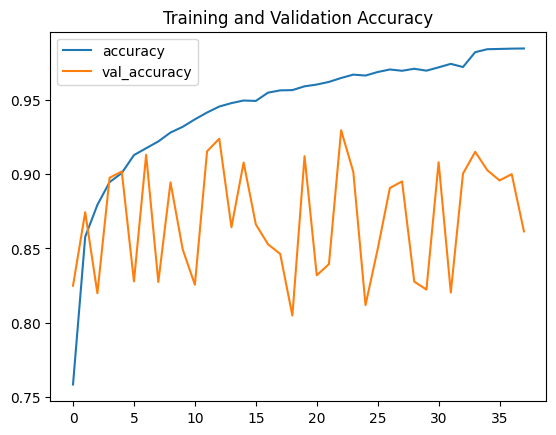

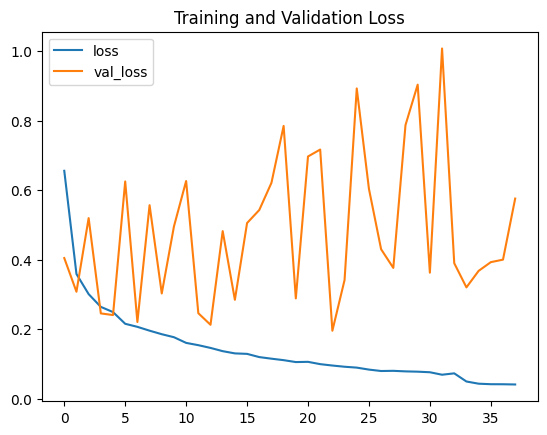

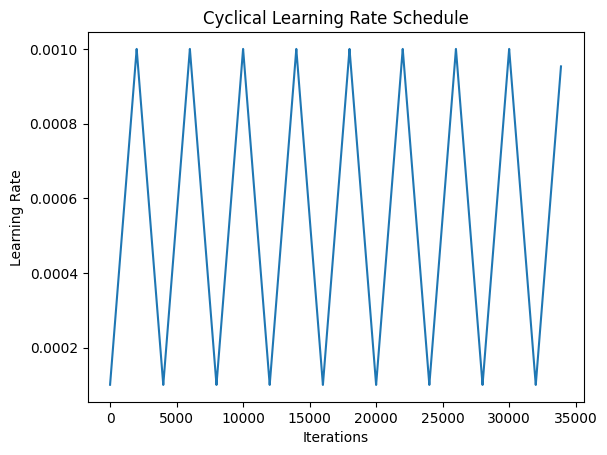

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## Test Loss: 0.19321

## Accuracy on the test set: 93.43%

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to print with Markdown
def printmd(string):
    display(Markdown(string))


# Load and preprocess dataset
image_dir = Path(r'E:\Abroad period research\new idea implementation codes\Second part of the paper\justchest_Unet_Segmented_Dataset')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop=True)

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
val_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=1)

# Create data generators with augmentation
def create_gen():
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0
    )

    val_images = val_test_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    test_images = val_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_images, val_images, test_images

# Load pre-trained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze some layers for fine-tuning
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-50]:
    layer.trainable = False

# Create data generators
train_images, val_images, test_images = create_gen()

# Custom Model with additional layers
inputs = pretrained_model.input
x = pretrained_model.output
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(image_df['Label'].unique()), activation='softmax')(x)

# Compile the model using Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Cyclical Learning Rate Callback
class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-2, step_size=2000., mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        return lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        self.clr_iterations = 0

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.clr_iterations += 1
        logs['lr'] = self.clr()
        self.history.setdefault('lr', []).append(logs['lr'])

# Callbacks
clr = CyclicLR(base_lr=1e-4, max_lr=1e-3, step_size=2000.)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6),
    clr
]

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size=32,
    epochs=50,
    callbacks=callbacks
)

# Save the trained model
model.save('Mobilenetv2_finetuned_with_CLR_and_GradientAccum.h5')

# Plot accuracy and loss curves
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Training and Validation Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Training and Validation Loss")
plt.show()

# Plot Cyclical Learning Rate
plt.plot(clr.history['lr'])
plt.title('Cyclical Learning Rate Schedule')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.show()

# Evaluate the model on the test set
results = model.evaluate(test_images, verbose=0)
printmd(f"## Test Loss: {results[0]:.5f}")
printmd(f"## Accuracy on the test set: {results[1] * 100:.2f}%")



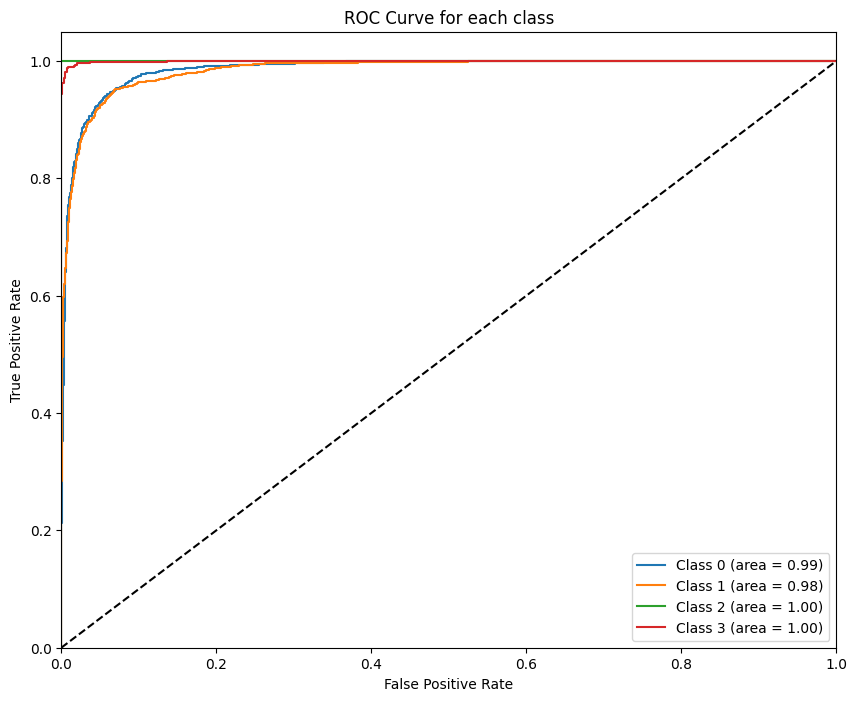

In [2]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Compute AUC-ROC for each class
y_true = test_images.classes  # Actual labels
y_pred_proba = model.predict(test_images, verbose=0)  # Predicted probabilities for each class
n_classes = len(image_df['Label'].unique())

# Binarize the output labels for each class (one-vs-rest)
from sklearn.preprocessing import label_binarize
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for each class")
plt.legend(loc="lower right")
plt.show()


192/192 ━━━━━━━━━━━━━━━━━━━━ 127s 661ms/step
                           precision    recall  f1-score   support

          COVID_Augmented       0.89      0.90      0.90      1529
   Lung_Opacity_Augmented       0.93      0.85      0.89      1568
                   Normal       0.95      1.00      0.97      1517
Viral Pneumonia_Augmented       0.96      0.99      0.98      1502

                 accuracy                           0.93      6116
                macro avg       0.93      0.94      0.93      6116
             weighted avg       0.93      0.93      0.93      6116



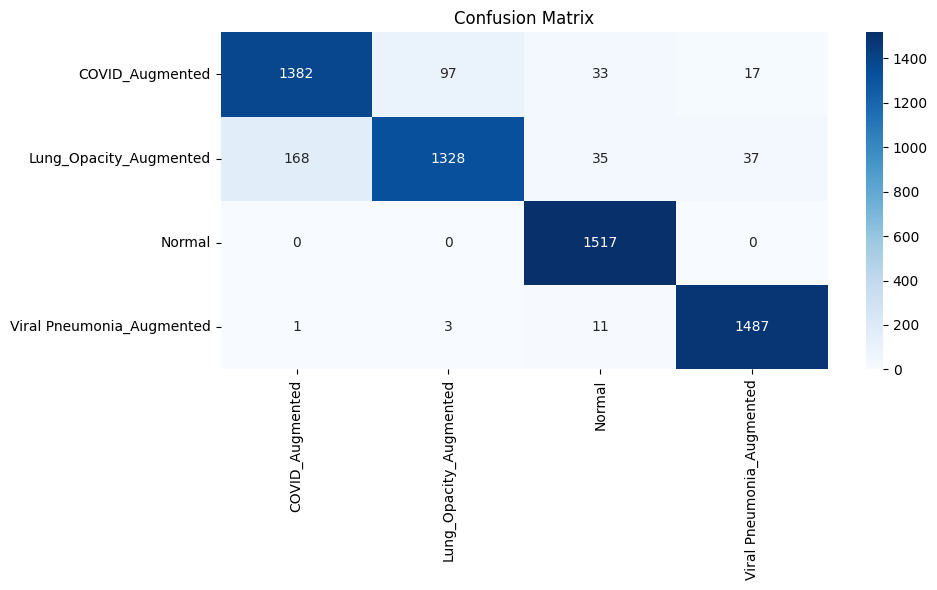

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)  # Assuming train_images is a data generator
labels = dict((v, k) for k, v in labels.items())  # Reverse the dictionary to get label mapping
pred = [labels[k] for k in pred]

# Assuming your test_df contains true labels for comparison
y_test = list(test_df['Label'])  # Replace 'Label' with the actual column name containing true labels

# Evaluation Metrics
print(classification_report(y_test, pred))

# Confusion matrix
cf_matrix = confusion_matrix(y_test, pred)

# Create the confusion matrix plot
plt.figure(figsize=(10, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)), cmap="Blues")
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Saving model

In [4]:
# Save the trained model
#keras.saving.save_model(model, 'my_model.keras')

Deep Feature extraction like i extracted in matlab 

In [5]:


# print("Features extracted and saved.")
import numpy as np
from tensorflow.keras.models import load_model, Model
import os
import pickle

# Load the pre-trained model
model_path = r'E:\Abroad period research\new idea implementation codes\Second part of the paper\Mobilenetv2_finetuned_with_CLR_and_GradientAccum.h5'
loaded_model = load_model(model_path)

# Define the feature extraction model
# Adjust the layer as needed; here, we use the fourth-last layer's output
feature_extractor = Model(inputs=loaded_model.input, outputs=loaded_model.layers[-4].output)

# Directory to save extracted features
feature_dir = 'extracted_features'
os.makedirs(feature_dir, exist_ok=True)

def extract_features(data_gen, set_name):
    features = []
    labels = []
    
    # Loop through batches in the data generator
    for batch_images, batch_labels in data_gen:
        # Extract features for the batch
        batch_features = feature_extractor.predict(batch_images)
        features.extend(batch_features)
        labels.extend(batch_labels)
        
        # Break if we’ve covered all images in the generator
        if data_gen.batch_index == 0:
            break

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Save extracted features and labels to a file
    with open(os.path.join(feature_dir, f"{set_name}_features.pkl"), 'wb') as f:
        pickle.dump((features, labels), f)

# Extract features for training, validation, and test sets
extract_features(train_images, "train")
extract_features(val_images, "val")
extract_features(test_images, "test")


print("Features extracted and saved.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

Classification of features using saved extracted features

In [195]:
# # Import necessary libraries
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import os
import numpy as np

# Directory to save extracted features and models
feature_dir = 'extracted_features'
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Load extracted features
with open(os.path.join(feature_dir, "train_features.pkl"), 'rb') as f:
    train_features, train_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "val_features.pkl"), 'rb') as f:
    val_features, val_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "test_features.pkl"), 'rb') as f:
    test_features, test_labels = pickle.load(f)

# Convert one-hot encoded labels to single-class labels
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_features, train_labels)

# Save the trained Decision Tree model
tree_model_path = os.path.join(model_dir, 'decision_tree_model.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(clf, f)

# Evaluate on training, validation, and test sets
for set_name, features, labels in [("Train", train_features, train_labels), ("Validation", val_features, val_labels), ("Test", test_features, test_labels)]:
    predictions = clf.predict(features)
    accuracy = accuracy_score(labels, predictions)
    print(f"{set_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{set_name} Confusion Matrix:\n", confusion_matrix(labels, predictions))
    print(f"{set_name} Classification Report:\n", classification_report(labels, predictions))

print(f"Decision Tree model saved to: {tree_model_path}")


Train Accuracy: 100.00%
Train Confusion Matrix:
 [[7089    0    0    0]
 [   0 7090    0    0]
 [   0    0 7237    0]
 [   0    0    0 7121]]
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7089
           1       1.00      1.00      1.00      7090
           2       1.00      1.00      1.00      7237
           3       1.00      1.00      1.00      7121

    accuracy                           1.00     28537
   macro avg       1.00      1.00      1.00     28537
weighted avg       1.00      1.00      1.00     28537

Validation Accuracy: 85.38%
Validation Confusion Matrix:
 [[1239  216  114    5]
 [ 262 1038  205   29]
 [   0    0 1438    0]
 [   3    7   53 1506]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1574
           1       0.82      0.68      0.74      1534
           2       0.79      1.00      0.89 

In [196]:
from sklearn.tree import export_text
import pickle

# Load the trained decision tree model
with open(tree_model_path, 'rb') as f:
    clf = pickle.load(f)

# Extract decision rules
tree_rules = export_text(clf, feature_names=[f'feature_{i}' for i in range(train_features.shape[1])])

# Display decision rules
print("Extracted Decision Tree Rules:\n")
print(tree_rules)


Extracted Decision Tree Rules:

|--- feature_14 <= 0.53
|   |--- feature_96 <= 2.06
|   |   |--- feature_79 <= 0.28
|   |   |   |--- feature_125 <= 0.76
|   |   |   |   |--- feature_79 <= 0.01
|   |   |   |   |   |--- feature_7 <= 2.10
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_7 >  2.10
|   |   |   |   |   |   |--- feature_109 <= 3.28
|   |   |   |   |   |   |   |--- feature_44 <= 2.83
|   |   |   |   |   |   |   |   |--- feature_126 <= 2.44
|   |   |   |   |   |   |   |   |   |--- feature_80 <= 0.55
|   |   |   |   |   |   |   |   |   |   |--- feature_36 <= 2.55
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- feature_36 >  2.55
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |--- feature_80 >  0.55
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_126 >  2.44
|   |   |   

USing Rulefit on the extracted deep features

In [18]:
import os
import pickle
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix

# Directory to save extracted features and models
feature_dir = 'extracted_features'
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Load extracted features
with open(os.path.join(feature_dir, "train_features.pkl"), 'rb') as f:
    train_features, train_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "val_features.pkl"), 'rb') as f:
    val_features, val_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "test_features.pkl"), 'rb') as f:
    test_features, test_labels = pickle.load(f)

# Check shapes of features and labels
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Features Shape:", val_features.shape)
print("Validation Labels Shape:", val_labels.shape)

# Ensure labels are aligned with features
assert train_features.shape[0] == train_labels.shape[0], "Mismatch between train features and labels."
assert val_features.shape[0] == val_labels.shape[0], "Mismatch between validation features and labels."

# Convert multi-dimensional labels to single class labels (if needed)
train_labels = np.argmax(train_labels, axis=1)  # Assuming one-hot encoding
val_labels = np.argmax(val_labels, axis=1)      # Assuming one-hot encoding
test_labels = np.argmax(test_labels, axis=1)    # If test labels are also one-hot encoded

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding or using a threshold
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_deep_features.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


Train Features Shape: (28537, 128)
Train Labels Shape: (28537, 4)
Validation Features Shape: (6115, 128)
Validation Labels Shape: (6115, 4)
Combined Training + Validation Features Shape: (34652, 128)
Combined Training + Validation Labels Shape: (34652,)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+02, tolerance: 4.337e+00
  model = cd_fast.enet_coordinate_descent(


Testing Accuracy: 0.9367
Confusion Matrix:
[[1323  176   26    4]
 [ 106 1412   43    7]
 [   0    0 1517    0]
 [   0    5   20 1477]]
Top Rules from RuleFit Model:
                                                   rule  type      coef  \
235   feature_27 <= 0.5105202198028564 & feature_57 ...  rule  0.236737   
192                     feature_96 > 2.1254204511642456  rule  0.208288   
795   feature_7 <= 1.4257643818855286 & feature_90 >...  rule  0.174227   
1251  feature_115 <= 1.3460692763328552 & feature_57...  rule  0.138048   
1732  feature_114 > 2.167609453201294 & feature_115 ...  rule  0.140150   

       support  importance  
235   0.262336    0.104142  
192   0.263158    0.091719  
795   0.240132    0.074423  
1251  0.254112    0.060101  
1732  0.229441    0.058929  
Rules have been saved to E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules.txt.


Calculate Statistical Features for Training, Validation, and Testing Sets

In [197]:
import numpy as np
import pandas as pd
from scipy.stats import skew, entropy
import os

# Load extracted features
feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/extracted_features'
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'

os.makedirs(stat_feature_dir, exist_ok=True)

with open(os.path.join(feature_dir, "train_features.pkl"), 'rb') as f:
    train_features, train_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "val_features.pkl"), 'rb') as f:
    val_features, val_labels = pickle.load(f)
    
with open(os.path.join(feature_dir, "test_features.pkl"), 'rb') as f:
    test_features, test_labels = pickle.load(f)

# Function to calculate statistical features
def calculate_statistical_features(features):
    stats_features = []
    for f in features:
        stats = {
            'mean': np.mean(f),
            'std_dev': np.std(f),
            'skewness': skew(f),
            'variance': np.var(f),
            'median': np.median(f),
            'range': np.ptp(f),  # Peak-to-peak range
            'entropy': entropy(np.abs(f) + 1e-6),  # Add small constant to avoid log(0)
            'energy': np.sum(f ** 2),
            'contrast': np.std(f) ** 2,  # Contrast as variance
            'mean_abs_dev': np.mean(np.abs(f - np.mean(f)))
        }
        stats_features.append(stats)
    return pd.DataFrame(stats_features)

# Convert labels to 1D if necessary (e.g., if labels are one-hot encoded)
def convert_labels_to_1d(labels):
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        # Assuming the labels are one-hot encoded, convert to single-class labels
        return np.argmax(labels, axis=1)
    return labels

# Calculate and save statistical features in CSV files
for set_name, features, labels in [("train", train_features, train_labels), 
                                   ("val", val_features, val_labels), 
                                   ("test", test_features, test_labels)]:
    stats_features_df = calculate_statistical_features(features)
    labels_1d = convert_labels_to_1d(labels)  # Ensure labels are 1D
    stats_features_df['label'] = labels_1d  # Append 1D labels to the DataFrame
    csv_file_path = os.path.join(stat_feature_dir, f"{set_name}_stat_features.csv")
    stats_features_df.to_csv(csv_file_path, index=False)

print("Statistical features calculated and saved to CSV files.")


Statistical features calculated and saved to CSV files.


Code for evaluating the statistical features (Mutual information and feature importance appraoch)
I used Mutual Information and Feature Importance to directly assess how well your statistical features relate to the class labels. If many features have low MI scores or feature importance values close to zero, they may not be contributing to the classification, and we might need to generate new features or revisit the feature extraction method.


In [198]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Load the statistical features and labels from CSV
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'

# Load the CSV file
train_df = pd.read_csv(f"{stat_feature_dir}/train_stat_features.csv")

# Separate features and labels
train_features = train_df.drop(columns=['label']).values  # Drop the 'label' column to get features
train_labels = train_df['label'].values  # Extract the labels

# Names of the statistical features (based on the columns in the CSV)
stat_feature_names = train_df.columns[:-1]  # All columns except 'label' are feature names

# 1. Mutual Information (MI) for each feature
# Mutual Information helps to see which features carry the most information about the target
mi_scores = mutual_info_classif(train_features, train_labels, discrete_features=False)
mi_scores_df = pd.DataFrame({'Feature': stat_feature_names, 'MI Score': mi_scores})
mi_scores_df.sort_values(by='MI Score', ascending=False, inplace=True)

# Display MI scores for each feature
print(mi_scores_df)


        Feature  MI Score
2      skewness  0.597950
6       entropy  0.540605
0          mean  0.390753
7        energy  0.333751
9  mean_abs_dev  0.318607
5         range  0.315449
8      contrast  0.309174
1       std_dev  0.309174
3      variance  0.309122
4        median  0.266401


Code for evaluating the statistical features (Calculate Information Gain)

In [199]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Load the statistical features and labels from CSV
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'

# Load the CSV file
train_df = pd.read_csv(f"{stat_feature_dir}/train_stat_features.csv")

# Separate features and labels
train_features = train_df.drop(columns=['label']).values  # Drop the 'label' column to get features
train_labels = train_df['label'].values  # Extract the labels

# Names of the statistical features (based on the columns in the CSV)
stat_feature_names = train_df.columns[:-1]  # All columns except 'label' are feature names

# 1. Calculate Information Gain using Decision Tree
# DecisionTreeClassifier uses information gain (or Gini impurity by default) for splits
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)  # Use 'entropy' to calculate information gain
decision_tree.fit(train_features, train_labels)

# Get feature importance (Information Gain for each feature)
information_gain = decision_tree.feature_importances_

# Create a DataFrame to display feature names with their respective Information Gain scores
info_gain_df = pd.DataFrame({'Feature': stat_feature_names, 'Information Gain': information_gain})
info_gain_df.sort_values(by='Information Gain', ascending=False, inplace=True)

# Display Information Gain for each feature
print(info_gain_df)


        Feature  Information Gain
2      skewness          0.387031
9  mean_abs_dev          0.158155
0          mean          0.134756
6       entropy          0.128579
4        median          0.085072
5         range          0.053980
7        energy          0.015697
8      contrast          0.014061
1       std_dev          0.013043
3      variance          0.009625


Load Statistical Features and Train & Evaluate Decision Tree Classifier

In [26]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the directory containing the CSV files
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'


# Load the CSV files
train_df = pd.read_csv(os.path.join(stat_feature_dir, "train_stat_features.csv"))
val_df = pd.read_csv(os.path.join(stat_feature_dir, "val_stat_features.csv"))
test_df = pd.read_csv(os.path.join(stat_feature_dir, "test_stat_features.csv"))

# Separate features and labels
train_stat_features = train_df.drop(columns=['label']).values
train_labels = train_df['label'].values

val_stat_features = val_df.drop(columns=['label']).values
val_labels = val_df['label'].values

test_stat_features = test_df.drop(columns=['label']).values
test_labels = test_df['label'].values

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_stat_features, train_labels)

# Evaluate on training, validation, and test sets
for set_name, features, labels in [("Train", train_stat_features, train_labels), 
                                   ("Validation", val_stat_features, val_labels), 
                                   ("Test", test_stat_features, test_labels)]:
    predictions = clf.predict(features)
    accuracy = accuracy_score(labels, predictions)
    print(f"{set_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{set_name} Confusion Matrix:\n", confusion_matrix(labels, predictions))
    print(f"{set_name} Classification Report:\n", classification_report(labels, predictions))


Train Accuracy: 100.00%
Train Confusion Matrix:
 [[7089    0    0    0]
 [   0 7090    0    0]
 [   0    0 7237    0]
 [   0    0    0 7121]]
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7089
           1       1.00      1.00      1.00      7090
           2       1.00      1.00      1.00      7237
           3       1.00      1.00      1.00      7121

    accuracy                           1.00     28537
   macro avg       1.00      1.00      1.00     28537
weighted avg       1.00      1.00      1.00     28537

Validation Accuracy: 52.74%
Validation Confusion Matrix:
 [[1066  361  134   13]
 [ 360  912  236   26]
 [  27    1    0 1410]
 [   6   10  306 1247]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70      1574
           1       0.71      0.59      0.65      1534
           2       0.00      0.00      0.00 

Save the Decision Tree Model (trained on statistical features)

In [201]:
import pickle
import os

# Directory to save model
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save the trained Decision Tree model
tree_model_path = os.path.join(model_dir, 'decision_tree_stat_model.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"Decision Tree model saved to: {tree_model_path}")


Decision Tree model saved to: saved_models\decision_tree_stat_model.pkl


Rules creation

Load and Extract Rules from the Decision Tree

In [202]:
from sklearn.tree import export_text

# Load the trained decision tree model
with open(tree_model_path, 'rb') as f:
    clf = pickle.load(f)

# Extract and display decision rules
tree_rules = export_text(clf, feature_names=['mean', 'std_dev', 'skewness', 'variance', 
                                             'median', 'range', 'entropy', 'energy', 
                                             'contrast', 'mean_abs_dev'])

print("Extracted Decision Tree Rules:\n")
print(tree_rules)


Extracted Decision Tree Rules:

|--- skewness <= 0.89
|   |--- median <= 0.04
|   |   |--- mean <= 1.07
|   |   |   |--- entropy <= 3.90
|   |   |   |   |--- range <= 4.35
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- range >  4.35
|   |   |   |   |   |--- mean_abs_dev <= 1.16
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- mean_abs_dev >  1.16
|   |   |   |   |   |   |--- class: 2
|   |   |   |--- entropy >  3.90
|   |   |   |   |--- skewness <= 0.79
|   |   |   |   |   |--- energy <= 343.62
|   |   |   |   |   |   |--- energy <= 229.80
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- energy >  229.80
|   |   |   |   |   |   |   |--- entropy <= 4.05
|   |   |   |   |   |   |   |   |--- entropy <= 4.04
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- entropy >  4.04
|   |   |   |   |   |   |   |   |   |--- entropy <= 4.04
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   

Decision Tree Rules in 'If-Then' Format

In [203]:
from sklearn.tree import _tree
import numpy as np
import pickle

# Load the trained decision tree model
with open(tree_model_path, 'rb') as f:
    clf = pickle.load(f)

# Define feature names
feature_names = ['mean', 'std_dev', 'skewness', 'variance', 'median', 
                 'range', 'entropy', 'energy', 'contrast', 'mean_abs_dev']

def tree_to_if_then_statements(tree, feature_names):
    """
    Extracts rules from a decision tree and returns them as a list of "if-then" statements.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []  # Store all rules as strings

    def recurse(node, depth, rule_str):
        # Recursive function to traverse the decision tree
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Left branch
            left_rule = f"{rule_str} if {name} <= {threshold:.3f}:"
            recurse(tree_.children_left[node], depth + 1, left_rule)
            
            # Right branch
            right_rule = f"{rule_str} if {name} > {threshold:.3f}:"
            recurse(tree_.children_right[node], depth + 1, right_rule)
        else:  # Leaf node
            value = tree_.value[node]
            class_label = np.argmax(value)
            rule_str += f" then class = {class_label}  # {value}"
            rules.append(rule_str)  # Add completed rule to the list

    # Start recursion
    recurse(0, 0, "")
    return rules

# Extract and display rules
rules = tree_to_if_then_statements(clf, feature_names)
print("Decision Tree Rules in 'If-Then' Format:\n")
for rule in rules:
    print(rule)


Decision Tree Rules in 'If-Then' Format:

 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy <= 3.903: if range <= 4.352: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy <= 3.903: if range > 4.352: if mean_abs_dev <= 1.165: then class = 3  # [[0. 0. 0. 1.]]
 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy <= 3.903: if range > 4.352: if mean_abs_dev > 1.165: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy > 3.903: if skewness <= 0.792: if energy <= 343.616: if energy <= 229.804: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy > 3.903: if skewness <= 0.792: if energy <= 343.616: if energy > 229.804: if entropy <= 4.051: if entropy <= 4.043: then class = 1  # [[0. 1. 0. 0.]]
 if skewness <= 0.893: if median <= 0.036: if mean <= 1.068: if entropy > 3.903: if skewness <= 0.792

Using Rulefit on statistical features calculated from deep features 

In [22]:
import os
import pandas as pd
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Define the directory containing the CSV files
input_dir = 'E:\Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'

# Load the CSV files
train_data = pd.read_csv(os.path.join(input_dir, "train_stat_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "val_stat_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "test_stat_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Define feature names based on your dataset
feature_names = ['mean', 'std_dev', 'skewness', 'variance', 'median', 
                 'range', 'entropy', 'energy', 'contrast', 'mean_abs_dev']  # Actual features names

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels, feature_names=feature_names)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding or using a threshold
# Since it's multiclass, we can round to the nearest integer or use argmax if using probabilities
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_statistical_features.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
C:\Users\hp\AppData\Local\Temp\ipykernel_11224\3194098961.py:9: SyntaxWarning: invalid escape sequence '\A'
  input_dir = 'E:\Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'


Combined Training + Validation Features Shape: (34652, 10)
Combined Training + Validation Labels Shape: (34652,)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+02, tolerance: 4.337e+00
  model = cd_fast.enet_coordinate_descent(


Testing Accuracy: 0.8345
Confusion Matrix:
[[1097  395   35    2]
 [ 202 1198  160    8]
 [   0    0 1514    3]
 [   0    1  206 1295]]
Top Rules from RuleFit Model:
                                                  rule  type      coef  \
242                      entropy <= 3.8878824710845947  rule  0.229582   
544  mean <= 1.8819448351860046 & entropy <= 3.9128...  rule  0.124825   
296  skewness > 0.8510673940181732 & median <= 0.29...  rule  0.119486   
600  entropy > 3.907556891441345 & skewness > 0.916...  rule -0.154724   
339  mean > 0.7097900211811066 & entropy > 4.030773...  rule -0.116923   

      support  importance  
242  0.365954    0.110589  
544  0.347039    0.059420  
296  0.432566    0.059197  
600  0.147204    0.054820  
339  0.313322    0.054234  
Rules have been saved to E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_statistical_features.txt.


Selecting Important Features and Saving Filtered Sets

In [8]:
import pandas as pd
import os

# Load statistical features from CSV files
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/statistical_features'
'

# Read CSV files for training, validation, and testing datasets
train_data = pd.read_csv(os.path.join(stat_feature_dir, "train_stat_features.csv"))
val_data = pd.read_csv(os.path.join(stat_feature_dir, "val_stat_features.csv"))
test_data = pd.read_csv(os.path.join(stat_feature_dir, "test_stat_features.csv"))

# Separate features and labels
feature_columns = ['mean', 'std_dev', 'skewness', 'variance', 
                   'median', 'range', 'entropy', 'energy', 
                   'contrast', 'mean_abs_dev']

# Assuming 'label' is already a column in the CSV files
train_stat_features = train_data[feature_columns].values
train_labels = train_data['label'].values

val_stat_features = val_data[feature_columns].values
val_labels = val_data['label'].values

test_stat_features = test_data[feature_columns].values
test_labels = test_data['label'].values

# Feature importance scores based on your provided data
info_gain_scores = {
    'skewness': 0.387031,
    'mean_abs_dev': 0.158155,
    'mean': 0.134756,
    'entropy': 0.128579,
    'median': 0.085072,
    'range': 0.053980,
    'energy': 0.015697,
    'contrast': 0.014061,
    'std_dev': 0.013043,
    'variance': 0.009625
}

mutual_info_scores = {
    'skewness': 0.597950,
    'entropy': 0.540605,
    'mean': 0.390753,
    'energy': 0.333751,
    'mean_abs_dev': 0.318607,
    'range': 0.315449,
    'contrast': 0.309174,
    'std_dev': 0.309174,
    'variance': 0.309122,
    'median': 0.266401
}

# Selecting features above thresholds in at least one metric
info_gain_threshold = 0.05
mutual_info_threshold = 0.5
selected_features = [feature for feature in info_gain_scores if (
    info_gain_scores[feature] > info_gain_threshold or mutual_info_scores[feature] > mutual_info_threshold)]

print("Selected features:", selected_features)

# Filter datasets to include only the selected features
train_selected = train_data[selected_features]
val_selected = val_data[selected_features]
test_selected = test_data[selected_features]

# Ensure labels match the length of the selected DataFrames
train_labels = np.ravel(train_labels)[:len(train_selected)]
val_labels = np.ravel(val_labels)[:len(val_selected)]
test_labels = np.ravel(test_labels)[:len(test_selected)]

# Add labels back to the filtered DataFrames
train_selected['label'] = train_labels
val_selected['label'] = val_labels
test_selected['label'] = test_labels

# Create folder for selected features
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features'
'
os.makedirs(selected_stat_feature_dir, exist_ok=True)

# Save the filtered feature sets (with labels) in the new folder
train_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"), index=False)
val_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"), index=False)
test_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"), index=False)

print("Filtered statistical features (with labels) saved in 'selected_statistical_features' folder.")


Selected features: ['skewness', 'mean_abs_dev', 'mean', 'entropy', 'median', 'range']


C:\Users\hp\AppData\Local\Temp\ipykernel_7280\493903210.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selected['label'] = train_labels
C:\Users\hp\AppData\Local\Temp\ipykernel_7280\493903210.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_selected['label'] = val_labels
C:\Users\hp\AppData\Local\Temp\ipykernel_7280\493903210.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

Filtered statistical features (with labels) saved in 'selected_statistical_features' folder.


Training, evaluation, and testing decision tree with selected features

In [10]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import os

# Define the directory where the selected statistical features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features'


# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree on the combined training and validation set
dt_classifier.fit(train_val_features, train_val_labels)

# Predict on the test set
test_predictions = dt_classifier.predict(test_features)

# Evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print evaluation results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")

# Save evaluation metrics
eval_metrics = {
    'accuracy': test_accuracy,
    'confusion_matrix': conf_matrix.tolist(),  # Convert to list for JSON compatibility
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Save metrics in a JSON file for easy reading
import json
with open(os.path.join(selected_stat_feature_dir, "decision_tree_eval_metrics.json"), 'w') as f:
    json.dump(eval_metrics, f)

print("Decision Tree trained and evaluated on selected features. Metrics saved.")


Test Accuracy: 70.23%
Confusion Matrix:
[[ 717  413  273   58]
 [ 467  768  150  149]
 [   8    3 1534    3]
 [  69   99  129 1276]]
Precision (weighted): 0.69
Recall (weighted): 0.70
F1 Score (weighted): 0.69
Decision Tree trained and evaluated on selected features. Metrics saved.


Using Rulefit on selected statistical features (6 features)

In [24]:
import os
import pandas as pd
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer


#Define the directory where the selected statistical features are saved
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(input_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Define feature names based on your dataset
feature_names = ['skewness', 'mean_abs_dev', 'mean', 'entropy', 'median', 'range'] # Actual features names

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels, feature_names=feature_names)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding or using a threshold
# Since it's multiclass, we can round to the nearest integer or use argmax if using probabilities
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_selected_6_statistical_features.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


Combined Training + Validation Features Shape: (34652, 6)
Combined Training + Validation Labels Shape: (34652,)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.186e+02, tolerance: 4.337e+00
  model = cd_fast.enet_coordinate_descent(


Testing Accuracy: 0.8353
Confusion Matrix:
[[1102  390   35    2]
 [ 211 1198  151    8]
 [   0    0 1514    3]
 [   0    1  206 1295]]
Top Rules from RuleFit Model:
                                                  rule  type      coef  \
756                      entropy <= 3.8885862827301025  rule  0.159496   
487  skewness > 0.9016022384166718 & mean <= 1.8801...  rule  0.142597   
228  entropy > 3.9238178730010986 & mean > 0.910229...  rule -0.125138   
957  mean > 0.9696650207042694 & entropy > 3.912801...  rule -0.111121   
594  mean > 0.8676856756210327 & entropy > 3.940155...  rule -0.108395   

      support  importance  
756  0.353618    0.076254  
487  0.269737    0.063288  
228  0.504112    0.062567  
957  0.440789    0.055170  
594  0.493421    0.054193  
Rules have been saved to E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_selected_6_statistical_features.txt.


Removing median feature from statistical features because it has more than 50% of data as zeros and executing the decision tree to find results

In [11]:
import numpy as np
import pandas as pd
import os

# Load statistical features
stat_feature_dir = 'statistical_features'

# Load CSV files instead of PKL
train_df = pd.read_csv(os.path.join(stat_feature_dir, "train_stat_features.csv"))
val_df = pd.read_csv(os.path.join(stat_feature_dir, "val_stat_features.csv"))
test_df = pd.read_csv(os.path.join(stat_feature_dir, "test_stat_features.csv"))

# Remove the 'median' column if it exists
train_df.drop(columns=['median'], errors='ignore', inplace=True)
val_df.drop(columns=['median'], errors='ignore', inplace=True)
test_df.drop(columns=['median'], errors='ignore', inplace=True)

# Feature importance scores based on your provided data
info_gain_scores = {
    'skewness': 0.387031,
    'mean_abs_dev': 0.158155,
    'mean': 0.134756,
    'entropy': 0.128579,
    'median': 0.085072,
    'range': 0.053980,
    'energy': 0.015697,
    'contrast': 0.014061,
    'std_dev': 0.013043,
    'variance': 0.009625
}

mutual_info_scores = {
    'skewness': 0.597950,
    'entropy': 0.540605,
    'mean': 0.390753,
    'energy': 0.333751,
    'mean_abs_dev': 0.318607,
    'range': 0.315449,
    'contrast': 0.309174,
    'std_dev': 0.309174,
    'variance': 0.309122,
    'median': 0.266401
}

# Selecting features above thresholds in at least one metric
info_gain_threshold = 0.05
mutual_info_threshold = 0.5
selected_features = [feature for feature in info_gain_scores if (
    info_gain_scores[feature] > info_gain_threshold or mutual_info_scores[feature] > mutual_info_threshold)]

# Ensure 'median' is removed from selected features if present
selected_features = [feature for feature in selected_features if feature != 'median']

print("Selected features:", selected_features)

# Filter datasets to include only the selected features
train_selected = train_df[selected_features]
val_selected = val_df[selected_features]
test_selected = test_df[selected_features]

# Assuming the labels are in the last column of the original CSV files
train_labels = train_df.iloc[:, -1].values
val_labels = val_df.iloc[:, -1].values
test_labels = test_df.iloc[:, -1].values

# Flatten the labels to ensure they are 1D arrays
train_labels_flat = np.ravel(train_labels)
val_labels_flat = np.ravel(val_labels)
test_labels_flat = np.ravel(test_labels)

# Add labels back to the filtered DataFrames
train_selected['label'] = train_labels_flat
val_selected['label'] = val_labels_flat
test_selected['label'] = test_labels_flat

# Create folder for selected features
selected_stat_feature_dir = 'selected_statistical_features_without_median'
os.makedirs(selected_stat_feature_dir, exist_ok=True)

# Save the filtered feature sets (with labels) in the new folder
train_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"), index=False)
val_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"), index=False)
test_selected.to_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"), index=False)

print("Filtered statistical features (with labels) saved in 'selected_statistical_features_without_median' folder.")


Selected features: ['skewness', 'mean_abs_dev', 'mean', 'entropy', 'range']


C:\Users\hp\AppData\Local\Temp\ipykernel_7280\3017295756.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_selected['label'] = train_labels_flat
C:\Users\hp\AppData\Local\Temp\ipykernel_7280\3017295756.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_selected['label'] = val_labels_flat
C:\Users\hp\AppData\Local\Temp\ipykernel_7280\3017295756.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Filtered statistical features (with labels) saved in 'selected_statistical_features_without_median' folder.


Executing tree on selected_statistical_features_without_median

In [12]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import os

# Define the directory where the selected statistical features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree on the combined training and validation set
dt_classifier.fit(train_val_features, train_val_labels)

# Predict on the test set
test_predictions = dt_classifier.predict(test_features)

# Evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print evaluation results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")

# Save evaluation metrics
eval_metrics = {
    'accuracy': test_accuracy,
    'confusion_matrix': conf_matrix.tolist(),  # Convert to list for JSON compatibility
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Save metrics in a JSON file for easy reading
import json
with open(os.path.join(selected_stat_feature_dir, "decision_tree_eval_metrics.json"), 'w') as f:
    json.dump(eval_metrics, f)

print("Decision Tree trained and evaluated on selected features. Metrics saved.")

import pickle
import os

# Directory to save model
model_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset//selected_statistical_features_without_median'
os.makedirs(model_dir, exist_ok=True)

# Save the trained Decision Tree model
tree_model_path = os.path.join(model_dir, 'decision_tree_final_stat_model_withoutmedian.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"Decision Tree model saved to: {tree_model_path}")


Test Accuracy: 81.16%
Confusion Matrix:
[[1111  346   65    7]
 [ 346 1039  159   24]
 [   0    0 1513    4]
 [   5   13  183 1301]]
Precision (weighted): 0.82
Recall (weighted): 0.81
F1 Score (weighted): 0.81
Decision Tree trained and evaluated on selected features. Metrics saved.
Decision Tree model saved to: E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset//selected_statistical_features_without_median\decision_tree_final_stat_model_withoutmedian.pkl


In [24]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import os
import json
import pickle

# Define the directory where the selected statistical features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label'])
train_labels = train_data['label']

val_features = val_data.drop(columns=['label'])
val_labels = val_data['label']

test_features = test_data.drop(columns=['label'])
test_labels = test_data['label']

# Combine training and validation data for final training
train_val_features = pd.concat([train_features, val_features], axis=0)
train_val_labels = pd.concat([train_labels, val_labels], axis=0)

# Calculate correlation between features and labels
correlation_matrix = train_val_features.corrwith(train_val_labels)
print("\nCorrelation Coefficient between each feature and label:\n", correlation_matrix)

# Save the correlation matrix to a CSV file
correlation_matrix.to_csv(os.path.join(selected_stat_feature_dir, "feature_label_correlations.csv"))

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree on the combined training and validation set
dt_classifier.fit(train_val_features, train_val_labels)

# Predict on the test set
test_predictions = dt_classifier.predict(test_features)

# Evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print evaluation results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")

# Save evaluation metrics
eval_metrics = {
    'accuracy': test_accuracy,
    'confusion_matrix': conf_matrix.tolist(),  # Convert to list for JSON compatibility
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

with open(os.path.join(selected_stat_feature_dir, "decision_tree_eval_metrics.json"), 'w') as f:
    json.dump(eval_metrics, f)

print("Decision Tree trained and evaluated on selected features. Metrics saved.")

# Save the trained Decision Tree model
model_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/saved_models'
os.makedirs(model_dir, exist_ok=True)

tree_model_path = os.path.join(model_dir, 'decision_tree_final_stat_model_withoutmedian.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(dt_classifier, f)

print(f"Decision Tree model saved to: {tree_model_path}")

skewness, Importance: 0.3794192778227698
Feature: mean_abs_dev, Importance: 0.3638663132968649
Feature: mean, Importance: 0.2567144088803652


Correlation Coefficient between each feature and label:
 skewness        0.788748
mean_abs_dev    0.038172
mean           -0.084829
entropy        -0.753712
range           0.279823
dtype: float64
Test Accuracy: 81.16%
Confusion Matrix:
[[1111  346   65    7]
 [ 346 1039  159   24]
 [   0    0 1513    4]
 [   5   13  183 1301]]
Precision (weighted): 0.82
Recall (weighted): 0.81
F1 Score (weighted): 0.81
Decision Tree trained and evaluated on selected features. Metrics saved.
Decision Tree model saved to: E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/saved_models\decision_tree_final_stat_model_withoutmedian.pkl


Rules extraction from the tree

In [13]:
import numpy as np
import pandas as pd
import pickle
from sklearn.tree import DecisionTreeClassifier, export_text
import os

# Define the directory where the selected statistical features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree on the combined training and validation set
dt_classifier.fit(train_val_features, train_val_labels)

# Save the trained Decision Tree model
tree_model_path = os.path.join(selected_stat_feature_dir, 'decision_tree_final_stat_model_withoutmedian.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(dt_classifier, f)

print(f"Decision Tree model saved to: {tree_model_path}")

# Extract and display decision rules
feature_names = train_data.drop(columns=['label']).columns.tolist()  # Get the feature names

# Extract decision rules
tree_rules = export_text(dt_classifier, feature_names=feature_names)

print("Extracted Decision Tree Rules:\n")
print(tree_rules)


Decision Tree model saved to: E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median\decision_tree_final_stat_model_withoutmedian.pkl
Extracted Decision Tree Rules:

|--- skewness <= 0.90
|   |--- entropy <= 4.01
|   |   |--- mean <= 1.14
|   |   |   |--- entropy <= 3.90
|   |   |   |   |--- class: 2
|   |   |   |--- entropy >  3.90
|   |   |   |   |--- range <= 3.62
|   |   |   |   |   |--- entropy <= 4.01
|   |   |   |   |   |   |--- mean <= 0.95
|   |   |   |   |   |   |   |--- mean <= 0.82
|   |   |   |   |   |   |   |   |--- entropy <= 3.94
|   |   |   |   |   |   |   |   |   |--- entropy <= 3.94
|   |   |   |   |   |   |   |   |   |   |--- range <= 3.01
|   |   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |   |   |--- range >  3.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |  

In [14]:
from sklearn.tree import _tree
import numpy as np
import pickle
import os

# Define the path to your saved decision tree model
tree_model_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median/decision_tree_final_stat_model_withoutmedian.pkl'

# Load the trained decision tree model
with open(tree_model_path, 'rb') as f:
    clf = pickle.load(f)





from sklearn.tree import _tree
import numpy as np
import pandas as pd
import os
import pickle

# Directory containing the statistical features CSV file
stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the trained decision tree model (assuming the model was saved as 'tree_model.pkl')
with open('E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median\decision_tree_final_stat_model_withoutmedian.pkl', 'rb') as f:
    clf = pickle.load(f)

# Load the statistical features CSV to get feature names (you can load any one of the datasets)
train_df = pd.read_csv(os.path.join(stat_feature_dir, "selected_training_statistical_features.csv"))

# Define feature names (assuming 'label' column contains the labels and all other columns are features)
feature_names = train_df.columns.drop('label').tolist()

def tree_to_if_then_statements(tree, feature_names):
    """
    Extracts rules from a decision tree and returns them as a list of "if-then" statements.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []  # Store all rules as strings

    def recurse(node, depth, rule_str):
        # Recursive function to traverse the decision tree
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Left branch
            left_rule = f"{rule_str} if {name} <= {threshold:.3f}:"
            recurse(tree_.children_left[node], depth + 1, left_rule)
            
            # Right branch
            right_rule = f"{rule_str} if {name} > {threshold:.3f}:"
            recurse(tree_.children_right[node], depth + 1, right_rule)
        else:  # Leaf node
            value = tree_.value[node]
            class_label = np.argmax(value)
            rule_str += f" then class = {class_label}  # {value}"
            rules.append(rule_str)  # Add completed rule to the list

    # Start recursion
    recurse(0, 0, "")
    return rules

# Extract and display rules
rules = tree_to_if_then_statements(clf, feature_names)
print("Decision Tree Rules in 'If-Then' Format:\n")
for rule in rules:
    print(rule)




<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hp\AppData\Local\Temp\ipykernel_7280\805290486.py:27: SyntaxWarning: invalid escape sequence '\d'
  with open('E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median\decision_tree_final_stat_model_withoutmedian.pkl', 'rb') as f:


Decision Tree Rules in 'If-Then' Format:

 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy <= 3.896: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if range <= 3.622: if entropy <= 4.008: if mean <= 0.948: if mean <= 0.821: if entropy <= 3.945: if entropy <= 3.942: if range <= 3.008: then class = 3  # [[0. 0. 0. 1.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if range <= 3.622: if entropy <= 4.008: if mean <= 0.948: if mean <= 0.821: if entropy <= 3.945: if entropy <= 3.942: if range > 3.008: if skewness <= 0.868: if range <= 3.223: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if range <= 3.622: if entropy <= 4.008: if mean <= 0.948: if mean <= 0.821: if entropy <= 3.945: if entropy <= 3.942: if range > 3.008: if skewness <= 0.868: if range > 3.223: then class = 3  # [[0. 0. 0. 1.]]
 if

Rulefit on selected 5 statistical features after median feature removal 

In [27]:
import os
import pandas as pd
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer


#Define the directory where the selected statistical features are saved
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(input_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Define feature names based on your dataset
feature_names = ['skewness', 'mean_abs_dev', 'mean', 'entropy', 'range'] # Actual features names

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels, feature_names=feature_names)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding or using a threshold
# Since it's multiclass, we can round to the nearest integer or use argmax if using probabilities
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_selected_5_statistical_features.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


Combined Training + Validation Features Shape: (34652, 5)
Combined Training + Validation Labels Shape: (34652,)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.748e+02, tolerance: 4.337e+00
  model = cd_fast.enet_coordinate_descent(


Testing Accuracy: 0.8337
Confusion Matrix:
[[1076  416   35    2]
 [ 197 1223  140    8]
 [   0    0 1514    3]
 [   0    1  215 1286]]
Top Rules from RuleFit Model:
                                                   rule  type      coef  \
524   entropy <= 3.916160821914673 & skewness > 0.92...  rule  0.243192   
165   mean > 1.002201497554779 & entropy <= 3.886584...  rule  0.136620   
1050  range > 2.992464780807495 & mean <= 1.89213562...  rule  0.115953   
313   entropy <= 3.963701009750366 & range > 2.99246...  rule  0.116138   
150   skewness <= 0.9640135169029236 & mean > 0.9817...  rule -0.108191   

       support  importance  
524   0.281250    0.109341  
165   0.256579    0.059668  
1050  0.456414    0.057756  
313   0.388980    0.056620  
150   0.424342    0.053473  
Rules have been saved to E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_on_selected_6_statistical_features.txt.


In [33]:
# Get feature importances from the decision tree
feature_importances = clf.feature_importances_

# Combine feature names with their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted features with importance
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


Feature Importances:
entropy: 0.5132
range: 0.3252
skewness: 0.1616


Classifying Selected Features Using Ensemble Methods

In [22]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import json

# Define the directory where the selected statistical features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected statistical features from CSV files
train_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_data = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

# Initialize the ensemble classifiers
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train and evaluate each model
ensemble_results = {}

for name, model in models.items():
    # Train the model on the combined training and validation data
    model.fit(train_val_features, train_val_labels)
    
    # Predict on the test set
    test_predictions = model.predict(test_features)
    
    # Evaluate the model
    test_accuracy = accuracy_score(test_labels, test_predictions)
    conf_matrix = confusion_matrix(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Store evaluation results
    ensemble_results[name] = {
        'accuracy': test_accuracy,
        'confusion_matrix': conf_matrix.tolist(),  # Convert to list for JSON compatibility
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # Print evaluation metrics
    print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision (weighted): {precision:.2f}")
    print(f"Recall (weighted): {recall:.2f}")
    print(f"F1 Score (weighted): {f1:.2f}")
    print("-" * 50)

# Save ensemble evaluation metrics to JSON file
with open(os.path.join(selected_stat_feature_dir, "ensemble_models_eval_metrics.json"), 'w') as f:
    json.dump(ensemble_results, f)

print("Ensemble models trained and evaluated. Metrics saved.")


Random Forest Test Accuracy: 84.86%
Confusion Matrix:
[[1152  312   62    3]
 [ 234 1151  166   17]
 [   0    1 1513    3]
 [   0    1  127 1374]]
Precision (weighted): 0.85
Recall (weighted): 0.85
F1 Score (weighted): 0.85
--------------------------------------------------
Gradient Boosting Test Accuracy: 83.98%
Confusion Matrix:
[[1112  353   58    6]
 [ 204 1167  173   24]
 [   0    0 1509    8]
 [   0    0  154 1348]]
Precision (weighted): 0.84
Recall (weighted): 0.84
F1 Score (weighted): 0.84
--------------------------------------------------


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Accuracy: 85.19%
Confusion Matrix:
[[1163  305   56    5]
 [ 233 1158  157   20]
 [   0    0 1512    5]
 [   0    3  122 1377]]
Precision (weighted): 0.85
Recall (weighted): 0.85
F1 Score (weighted): 0.85
--------------------------------------------------
Ensemble models trained and evaluated. Metrics saved.


Results on selected features using correlation based feature selection approach, CFS resulted these important features, Range, skewness, entropy

In [28]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

# Define directories for features and models
feature_dir = 'statistical_features'  # Your directory with .csv files
output_dir = 'CFS_selected_features_Set'  # Folder for saving the selected features
os.makedirs(output_dir, exist_ok=True)

# Load the CSV files for training, validation, and testing datasets
train_data = pd.read_csv(os.path.join(feature_dir, "train_stat_features.csv"))
val_data = pd.read_csv(os.path.join(feature_dir, "val_stat_features.csv"))
test_data = pd.read_csv(os.path.join(feature_dir, "test_stat_features.csv"))

# Separate features and labels
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Selected important features based on correlation-based feature selection
selected_features = ['range', 'skewness', 'entropy']

# Get the indices of the selected features
feature_names = list(train_data.columns[:-1])  # Assuming the last column is 'label'
selected_indices = [feature_names.index(f) for f in selected_features]

# Select only the chosen features
train_selected = train_features[:, selected_indices]
val_selected = val_features[:, selected_indices]
test_selected = test_features[:, selected_indices]

# Combine training and validation datasets
train_val_features = np.concatenate([train_selected, val_selected], axis=0)
train_val_labels = np.concatenate([train_labels, val_labels], axis=0)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_val_features, train_val_labels)

# Save the selected features with corresponding labels in the new folder
train_selected_df = pd.DataFrame(train_selected, columns=selected_features)
train_selected_df['label'] = train_labels
train_selected_df.to_csv(os.path.join(output_dir, "CFS_training_selected_features.csv"), index=False)

val_selected_df = pd.DataFrame(val_selected, columns=selected_features)
val_selected_df['label'] = val_labels
val_selected_df.to_csv(os.path.join(output_dir, "CFS_validation_selected_features.csv"), index=False)

test_selected_df = pd.DataFrame(test_selected, columns=selected_features)
test_selected_df['label'] = test_labels
test_selected_df.to_csv(os.path.join(output_dir, "CFS_testing_selected_features.csv"), index=False)

# Save the trained Decision Tree model
tree_model_path = os.path.join(output_dir, 'decision_tree_model_CFS.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(clf, f)

# Evaluate on training, validation, and test sets
for set_name, features, labels in [("Train/Validation", train_val_features, train_val_labels), ("Test", test_selected, test_labels)]:
    predictions = clf.predict(features)
    accuracy = accuracy_score(labels, predictions)
    print(f"{set_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{set_name} Confusion Matrix:\n", confusion_matrix(labels, predictions))
    print(f"{set_name} Classification Report:\n", classification_report(labels, predictions))

print(f"Decision Tree model and selected feature sets saved to: {output_dir}")


Train/Validation Accuracy: 100.00%
Train/Validation Confusion Matrix:
 [[8663    0    0    0]
 [   0 8624    0    0]
 [   0    0 8675    0]
 [   0    0    0 8690]]
Train/Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8663
           1       1.00      1.00      1.00      8624
           2       1.00      1.00      1.00      8675
           3       1.00      1.00      1.00      8690

    accuracy                           1.00     34652
   macro avg       1.00      1.00      1.00     34652
weighted avg       1.00      1.00      1.00     34652

Test Accuracy: 76.95%
Test Confusion Matrix:
 [[1008  418  101    2]
 [ 393  973  166   36]
 [   0    1 1489   27]
 [   7   13  246 1236]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69      1529
           1       0.69      0.62      0.65      1568
           2       0.74      

Applying mutual information based approach to select k best features in this case i selected 3 best features

In [45]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Define the input directory where the selected statistical features are saved
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Define the output directory for saving selected features after CFS
output_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'
os.makedirs(output_dir, exist_ok=True)

# Function to apply CFS and save selected features
def apply_mic_and_save(data, selected_columns, output_name):
    # Separate features and labels
    X = data[selected_columns]  # Use only the selected features
    y = data['label']  # Labels
    
    # Add the label back to the selected features
    selected_data = pd.concat([X, y], axis=1)
    
    # Save the selected features with labels
    selected_data.to_csv(os.path.join(output_dir, output_name), index=False)

# Step 1: Perform feature selection on the training set
train_data = pd.read_csv(os.path.join(input_dir, "selected_training_statistical_features.csv"))

# Separate features and labels for the training set
X_train = train_data.drop(columns=['label'])  # Features
y_train = train_data['label']  # Labels

# Use mutual information on training data to select top 3 features
selector = SelectKBest(score_func=mutual_info_classif, k=3)  # Select top 3 features
selector.fit(X_train, y_train)

# Get the selected feature names based on training set
selected_columns = X_train.columns[selector.get_support()]
print(f"Selected features based on training set: {selected_columns}")

# Step 2: Apply the same selected features to the training, validation, and testing datasets

# Apply CFS to the training set (using selected features)
apply_mic_and_save(train_data, selected_columns, "CFS_training_selected_features.csv")

# Apply the same selected features to the validation set
val_data = pd.read_csv(os.path.join(input_dir, "selected_validation_statistical_features.csv"))
apply_mic_and_save(val_data, selected_columns, "CFS_validation_selected_features.csv")

# Apply the same selected features to the testing set
test_data = pd.read_csv(os.path.join(input_dir, "selected_testing_statistical_features.csv"))
apply_mic_and_save(test_data, selected_columns, "CFS_testing_selected_features.csv")

print("Feature selection completed and saved.")


Selected features based on training set: Index(['skewness', 'mean', 'entropy'], dtype='object')
Feature selection completed and saved.


In [5]:
import os
import pandas as pd
import numpy as np

# Define the output directory where the CFS-selected features are saved
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'

# Load the selected features from CSV files after CFS
train_data = pd.read_csv(os.path.join(input_dir, "CFS_training_selected_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "CFS_testing_selected_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "CFS_validation_selected_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

# Display the shape of the combined data
print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Train a decision tree classifier on the combined training and validation data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_val_features, train_val_labels)

# Predict on the test set
test_predictions = clf.predict(test_features)

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)



Combined Training + Validation Features Shape: (34652, 3)
Combined Training + Validation Labels Shape: (34652,)
Testing Accuracy: 0.8090
Confusion Matrix:
[[1104  343   77    5]
 [ 344 1039  167   18]
 [   0    0 1513    4]
 [   5   16  189 1292]]



Decision Tree Rules (Text-Based):
|--- skewness <= 0.90
|   |--- entropy <= 4.01
|   |   |--- mean <= 1.14
|   |   |   |--- entropy <= 3.90
|   |   |   |   |--- class: 2
|   |   |   |--- entropy >  3.90
|   |   |   |   |--- mean <= 0.82
|   |   |   |   |   |--- entropy <= 4.01
|   |   |   |   |   |   |--- entropy <= 3.94
|   |   |   |   |   |   |   |--- entropy <= 3.94
|   |   |   |   |   |   |   |   |--- skewness <= 0.87
|   |   |   |   |   |   |   |   |   |--- entropy <= 3.92
|   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |   |--- entropy >  3.92
|   |   |   |   |   |   |   |   |   |   |--- entropy <= 3.93
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |   |--- entropy >  3.93
|   |   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- skewness >  0.87
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- entropy >  3.94
|   |   |   | 

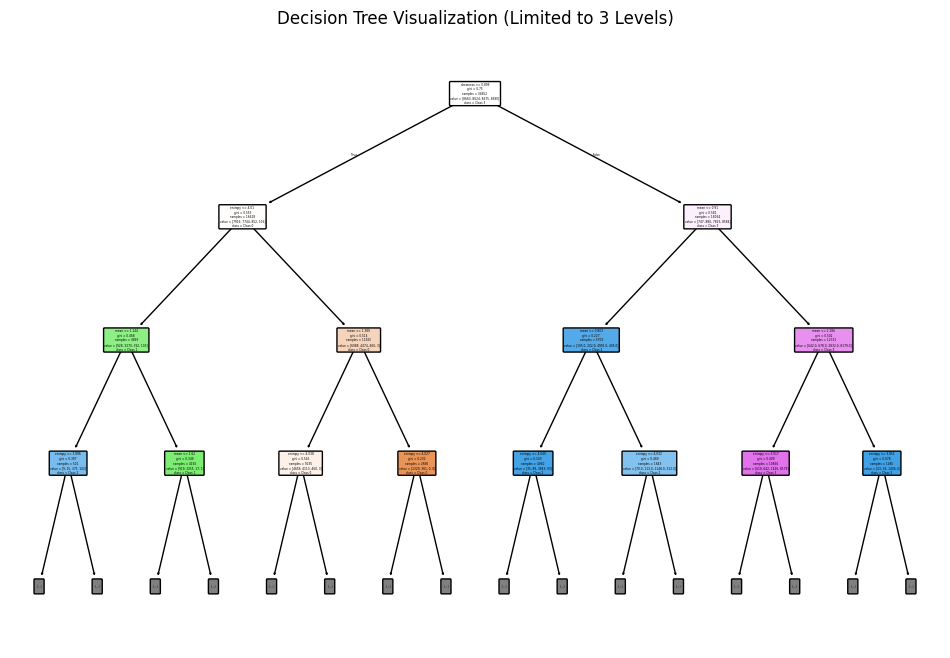

In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_text, plot_tree

# Load the trained Decision Tree model from the pickle file
model_dir = 'saved_models'
tree_model_path = os.path.join(model_dir, 'decision_tree_final_stat_model_with_final_three_features.pkl')

with open(tree_model_path, 'rb') as f:
    decision_tree = pickle.load(f)

# Load the selected features from CSV files (update the input_dir as needed)
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'
train_data = pd.read_csv(os.path.join(input_dir, "CFS_training_selected_features.csv"))

# Separate features and labels
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

# Define feature names based on your dataset
feature_names = ['skewness', 'mean', 'entropy']  # Update based on your actual features

# Automatically get class names based on unique labels in the dataset
class_names = [f'Class {i}' for i in np.unique(train_labels)]

# --- Method 1: Text-Based Visualization ---
tree_rules = export_text(decision_tree, feature_names=feature_names)
print("\nDecision Tree Rules (Text-Based):")
print(tree_rules)

# --- Method 2: Plotting the Decision Tree (limited to 3 levels) ---
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Limited to 3 Levels)")
plt.show()


Saving decision tree

In [47]:
import pickle
import os

# Directory to save model
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save the trained Decision Tree model
tree_model_path = os.path.join(model_dir, 'decision_tree_final_stat_model_with_final_three_features.pkl')
with open(tree_model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"Decision Tree model saved to: {tree_model_path}")


Decision Tree model saved to: saved_models\decision_tree_final_stat_model_with_final_three_features.pkl


Extracting rules from this tree

In [68]:
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import _tree

# Load the trained decision tree model
model_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/saved_models/decision_tree_final_stat_model_with_final_three_features.pkl'
with open(model_path, 'rb') as f:
    clf = pickle.load(f)

# Define feature names (update these based on your selected features)
feature_names = ['skewness', 'mean', 'entropy']  # Update according to your selected features

def tree_to_if_then_statements(tree, feature_names):
    """
    Extracts rules from a decision tree and returns them as a list of "if-then" statements.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []  # Store all rules as strings

    def recurse(node, rule_str):
        # Recursive function to traverse the decision tree
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Left branch
            left_rule = f"{rule_str} if {name} <= {threshold:.3f}:"
            recurse(tree_.children_left[node], left_rule)
            
            # Right branch
            right_rule = f"{rule_str} if {name} > {threshold:.3f}:"
            recurse(tree_.children_right[node], right_rule)
        else:  # Leaf node
            value = tree_.value[node]
            class_label = np.argmax(value)
            rule_str += f" then class = {class_label}  # {value}"
            rules.append(rule_str)  # Add completed rule to the list

    # Start recursion
    recurse(0, "")
    return rules

# Extract rules
rules = tree_to_if_then_statements(clf, feature_names)

# Display the total number of rules
total_rules = len(rules)  # Get the number of rules in the list
print(f"Total Number of Rules: {total_rules}")

# Display rules in the console
print("Decision Tree Rules in 'If-Then' Format:\n")
for rule in rules:
    print(rule)
    


# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/final_decision_tree_3best_features_rules.txt'  # Specify the output file name
with open(output_file_path, 'w') as f:
    for rule in rules:
        f.write(rule + '\n')  # Write each rule on a new line

print(f"\nRules have been saved to {output_file_path}.")


Total Number of Rules: 4744
Decision Tree Rules in 'If-Then' Format:

 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy <= 3.896: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if mean <= 0.821: if entropy <= 4.008: if entropy <= 3.945: if entropy <= 3.942: if skewness <= 0.870: if entropy <= 3.921: then class = 3  # [[0. 0. 0. 1.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if mean <= 0.821: if entropy <= 4.008: if entropy <= 3.945: if entropy <= 3.942: if skewness <= 0.870: if entropy > 3.921: if entropy <= 3.934: then class = 2  # [[0. 0. 1. 0.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <= 1.144: if entropy > 3.896: if mean <= 0.821: if entropy <= 4.008: if entropy <= 3.945: if entropy <= 3.942: if skewness <= 0.870: if entropy > 3.921: if entropy > 3.934: then class = 3  # [[0. 0. 0. 1.]]
 if skewness <= 0.899: if entropy <= 4.010: if mean <=

Using Rulefit to classify dataset and extract rules

In [ ]:
import os
import pandas as pd
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Load the selected features from CSV files after SelectKBest
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'

train_data = pd.read_csv(os.path.join(input_dir, "CFS_training_selected_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "CFS_testing_selected_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "CFS_validation_selected_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Define feature names based on your dataset
feature_names = ['skewness', 'mean', 'entropy']  # Update based on your actual features

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels, feature_names=feature_names)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding or using a threshold
# Since it's multiclass, we can round to the nearest integer or use argmax if using probabilities
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Save rules to a text file
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules_with_final_3_Statistical_features.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


Combined Training + Validation Features Shape: (34652, 3)
Combined Training + Validation Labels Shape: (34652,)


Combined Training + Validation Features Shape: (34652, 3)
Combined Training + Validation Labels Shape: (34652,)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.930e+01, tolerance: 4.337e+00
  model = cd_fast.enet_coordinate_descent(


Testing Accuracy: 0.8223
Confusion Matrix:
[[1044  442   41    2]
 [ 205 1201  153    9]
 [   0    0 1514    3]
 [   0    2  230 1270]]
Top Rules from RuleFit Model:
                                                   rule  type      coef  \
1093  entropy <= 3.916160821914673 & skewness > 0.92...  rule  0.224441   
1182  entropy <= 3.9375486373901367 & skewness > 0.8...  rule  0.148396   
858   entropy > 3.9806638956069946 & skewness <= 0.9...  rule -0.114812   
1021  mean > 1.3091812133789062 & entropy > 3.875972...  rule -0.118020   
833   skewness <= 0.8956682682037354 & entropy > 3.9...  rule -0.109580   

       support  importance  
1093  0.281250    0.100911  
1182  0.217105    0.061180  
858   0.425987    0.056774  
1021  0.277138    0.052824  
833   0.361020    0.052631  


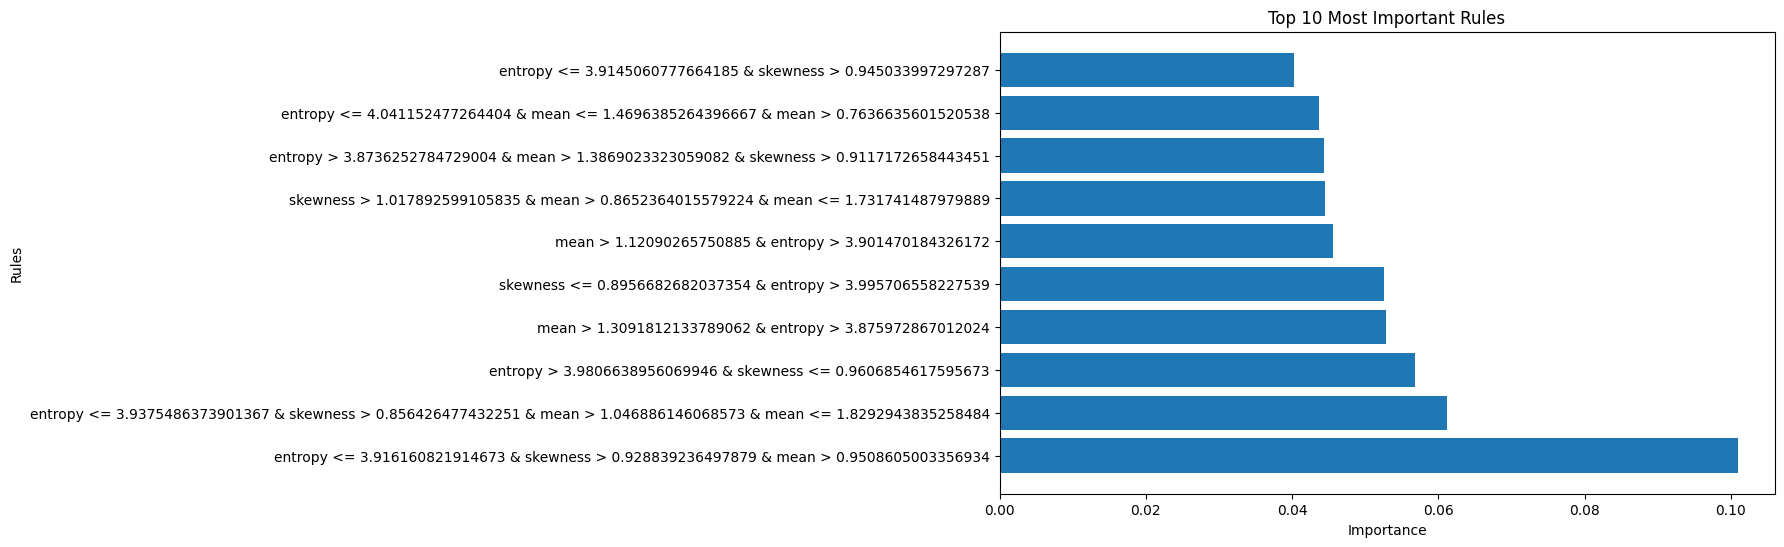

Rules have been saved to E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules.txt.


In [1]:
import os
import pandas as pd
import numpy as np
from rulefit import RuleFit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_text
import matplotlib.pyplot as plt

# Load the selected features from CSV files
input_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'

train_data = pd.read_csv(os.path.join(input_dir, "CFS_training_selected_features.csv"))
test_data = pd.read_csv(os.path.join(input_dir, "CFS_testing_selected_features.csv"))
val_data = pd.read_csv(os.path.join(input_dir, "CFS_validation_selected_features.csv"))

# Separate features and labels for each dataset
train_features = train_data.drop(columns=['label']).values
train_labels = train_data['label'].values

val_features = val_data.drop(columns=['label']).values
val_labels = val_data['label'].values

test_features = test_data.drop(columns=['label']).values
test_labels = test_data['label'].values

# Combine training and validation data for final training
train_val_features = np.vstack([train_features, val_features])
train_val_labels = np.hstack([train_labels, val_labels])

print(f"Combined Training + Validation Features Shape: {train_val_features.shape}")
print(f"Combined Training + Validation Labels Shape: {train_val_labels.shape}")

# Define feature names based on your dataset
feature_names = ['skewness', 'mean', 'entropy']  # Update based on your actual features

# Initialize RuleFit model
rf = RuleFit(tree_size=3, sample_fract=1.0, max_rules=2000, random_state=42)

# Fit the RuleFit model to combined training and validation data
rf.fit(train_val_features, train_val_labels, feature_names=feature_names)

# Predict on the test set (continuous values)
test_predictions = rf.predict(test_features)

# Convert continuous predictions to discrete class labels by rounding
test_predictions_discrete = np.round(test_predictions).astype(int)

# Ensure the predicted labels are within the valid range of classes
test_predictions_discrete = np.clip(test_predictions_discrete, np.min(train_val_labels), np.max(train_val_labels))

# Calculate testing accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_discrete)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_discrete)
print("Confusion Matrix:")
print(conf_matrix)

# Extract rules from the RuleFit model
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# Display the top rules
print("Top Rules from RuleFit Model:")
print(rules.head())

# Visualizing Rule Importance as a Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(rules['rule'][:10], rules['importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Rules')
plt.title('Top 10 Most Important Rules')
plt.show()

# Save rules to a text file for reference
output_file_path = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/rulefit_rules.txt'
rules.to_csv(output_file_path, index=False)
print(f"Rules have been saved to {output_file_path}.")


In [65]:
# Display the total number of rules
total_rules = rules.shape[0]  # Number of rows in the DataFrame
print(f"Total Number of Rules: {total_rules}")

Total Number of Rules: 169


Explainable Boosting Machines (EBMs)

In [69]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the EBM classifier
ebm = ExplainableBoostingClassifier(random_state=42)

# Train on the combined training and validation data
ebm.fit(train_val_features, train_val_labels)

# Predict on the test set
test_predictions = ebm.predict(test_features)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Extract and display EBM model insights
global_explanation = ebm.explain_global()
print(global_explanation.data())


Testing Accuracy: 0.8216
Confusion Matrix:
[[1101  356   67    5]
 [ 287 1076  166   39]
 [   0    0 1511    6]
 [   1    1  163 1337]]
{'type': 'univariate', 'names': ['feature_0000', 'feature_0001', 'feature_0002'], 'scores': [1.0851898849570856, 1.952564853462976, 3.0728193844583713]}


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1014: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


Association Rule Mining (using Apriori algorithm) creation from my final selected features without median 

In [51]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

## Load the selected statistical features and labels
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'
train_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_training_selected_features.csv"))
val_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_testing_selected_features.csv"))
test_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_validation_selected_features.csv"))



# Step 2: Prepare the data by concatenating all datasets for consistent thresholding
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Step 3: Binarize the features based on mean threshold
thresholds = combined_df.mean()

# Create binary features based on whether they are above or below the mean
for feature in thresholds.index[:-1]:  # Exclude the 'label' column
    combined_df[feature] = combined_df[feature] > thresholds[feature]

# Split the data back into training, validation, and testing sets after binarization
train_bin = combined_df.iloc[:len(train_df)]
val_bin = combined_df.iloc[len(train_df):len(train_df) + len(val_df)]
test_bin = combined_df.iloc[len(train_df) + len(val_df):]

# Step 4: Generate frequent itemsets using the binarized training set (excluding the 'label' column)
frequent_itemsets = apriori(train_bin.drop(columns=['label']), min_support=0.1, use_colnames=True)

# Step 5: Extract association rules from the frequent itemsets based on confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Display the generated association rules
print("Association Rules:")
print(rules)

# Step 6: Optionally save the association rules to a CSV file
rules.to_csv('association_rules.csv', index=False)

# Evaluate the rules: For example, display the top 5 association rules based on lift
top_rules = rules.sort_values(by='lift', ascending=False).head(5)
print("Top 5 Association Rules based on lift:")
print(top_rules)


Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0      (mean)   (entropy)            0.343484            0.565967  0.223324   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.650173  1.148783  0.028924    1.240709       0.197274  
Top 5 Association Rules based on lift:
  antecedents consequents  antecedent support  consequent support   support  \
0      (mean)   (entropy)            0.343484            0.565967  0.223324   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.650173  1.148783  0.028924    1.240709       0.197274  


Association rules on final feature set with accuracy of 85%

In [61]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import os

## Load the selected statistical features and labels
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/features after SelectKBest'
train_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_training_selected_features.csv"))
val_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_testing_selected_features.csv"))
test_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "CFS_validation_selected_features.csv"))

# Step 2: Prepare the data by concatenating all datasets for consistent thresholding
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Step 3: Binarize the features based on mean threshold
thresholds = combined_df.mean()

# Create binary features based on whether they are above or below the mean
for feature in thresholds.index[:-1]:  # Exclude the 'label' column
    combined_df[feature] = combined_df[feature] > thresholds[feature]

# Handle NaN values by filling them with False (or 0)
combined_df.fillna(False, inplace=True)  # Fill NaNs with False for binary features

# Split the data back into training, validation, and testing sets after binarization
train_bin = combined_df.iloc[:len(train_df)]
val_bin = combined_df.iloc[len(train_df):len(train_df) + len(val_df)]
test_bin = combined_df.iloc[len(train_df) + len(val_df):]

# Step 4: Generate frequent itemsets using the binarized training set (excluding the 'label' column)
frequent_itemsets = apriori(train_bin.drop(columns=['label']), min_support=0.05, use_colnames=True)

# Step 5: Extract association rules from the frequent itemsets based on confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)

# Function to display rules in IF-THEN format
def display_rules_in_if_then_format(rules_df):
    for index, row in rules_df.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        antecedent_str = " AND ".join([str(antecedent) + " = True" for antecedent in antecedents])
        consequent_str = " AND ".join([str(consequent) + " = True" for consequent in consequents])
        
        print(f"IF {antecedent_str} THEN {consequent_str} "
              f"(support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f})")

# Display the association rules in the form of IF-THEN
print("Association Rules in IF-THEN format:")
display_rules_in_if_then_format(rules)

# Optionally save the association rules in IF-THEN format to a text file
with open('if_then_association_rules.txt', 'w') as f:
    for index, row in rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        antecedent_str = " AND ".join([str(antecedent) + " = True" for antecedent in antecedents])
        consequent_str = " AND ".join([str(consequent) + " = True" for consequent in consequents])
        
        rule_text = (f"IF {antecedent_str} THEN {consequent_str} "
                     f"(support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f})\n")
        f.write(rule_text)

# Step 6: Optionally save the original association rules to a CSV file
rules.to_csv('association_rules.csv', index=False)

# Evaluate the rules: For example, display the top 5 association rules based on lift
top_rules = rules.sort_values(by='lift', ascending=False).head(5)
print("\nTop 5 Association Rules based on lift in IF-THEN format:")
display_rules_in_if_then_format(top_rules)


Association Rules in IF-THEN format:
IF mean = True THEN skewness = True (support: 0.10, confidence: 0.28, lift: 0.65)
IF skewness = True THEN mean = True (support: 0.10, confidence: 0.22, lift: 0.65)
IF skewness = True THEN entropy = True (support: 0.07, confidence: 0.15, lift: 0.27)
IF entropy = True THEN skewness = True (support: 0.07, confidence: 0.12, lift: 0.27)
IF mean = True THEN entropy = True (support: 0.22, confidence: 0.65, lift: 1.15)
IF entropy = True THEN mean = True (support: 0.22, confidence: 0.39, lift: 1.15)

Top 5 Association Rules based on lift in IF-THEN format:
IF mean = True THEN entropy = True (support: 0.22, confidence: 0.65, lift: 1.15)
IF entropy = True THEN mean = True (support: 0.22, confidence: 0.39, lift: 1.15)
IF mean = True THEN skewness = True (support: 0.10, confidence: 0.28, lift: 0.65)
IF skewness = True THEN mean = True (support: 0.10, confidence: 0.22, lift: 0.65)
IF skewness = True THEN entropy = True (support: 0.07, confidence: 0.15, lift: 0.27

Generation of rules extracted using Apriori algorithm in the form of if then

In [23]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Define the output directory where the CFS-selected features are saved
selected_stat_feature_dir = 'E:/Abroad period research/new idea implementation codes/Second part of the paper/Results on augmented just chest dataset/selected_statistical_features_without_median'

# Load the selected features from CSV files after CFS
train_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
test_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))
val_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))


# Step 2: Prepare the data by concatenating all datasets for consistent thresholding
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Step 3: Binarize the features based on mean threshold
thresholds = combined_df.mean()

# Create binary features based on whether they are above or below the mean
for feature in thresholds.index[:-1]:  # Exclude the 'label' column
    combined_df[feature] = combined_df[feature] > thresholds[feature]

# Split the data back into training, validation, and testing sets after binarization
train_bin = combined_df.iloc[:len(train_df)]
val_bin = combined_df.iloc[len(train_df):len(train_df) + len(val_df)]
test_bin = combined_df.iloc[len(train_df) + len(val_df):]

# Step 4: Generate frequent itemsets using the binarized training set (excluding the 'label' column)
frequent_itemsets = apriori(train_bin.drop(columns=['label']), min_support=0.1, use_colnames=True)

# Step 5: Extract association rules from the frequent itemsets based on confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Function to display rules in IF-THEN format
def display_rules_in_if_then_format(rules_df):
    for index, row in rules_df.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        antecedent_str = " AND ".join([str(antecedent) + " = True" for antecedent in antecedents])
        consequent_str = " AND ".join([str(consequent) + " = True" for consequent in consequents])
        
        print(f"IF {antecedent_str} THEN {consequent_str} "
              f"(support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f})")

# Display the association rules in the form of IF-THEN
print("Association Rules in IF-THEN format:")
display_rules_in_if_then_format(rules)

# Optionally save the association rules in IF-THEN format to a text file
with open('if_then_association_rules.txt', 'w') as f:
    for index, row in rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        antecedent_str = " AND ".join([str(antecedent) + " = True" for antecedent in antecedents])
        consequent_str = " AND ".join([str(consequent) + " = True" for consequent in consequents])
        
        rule_text = (f"IF {antecedent_str} THEN {consequent_str} "
                     f"(support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f})\n")
        f.write(rule_text)

# Step 6: Optionally save the original association rules to a CSV file
rules.to_csv('association_rules.csv', index=False)

# Evaluate the rules: For example, display the top 5 association rules based on lift
top_rules = rules.sort_values(by='lift', ascending=False).head(5)
print("\nTop 5 Association Rules based on lift in IF-THEN format:")
display_rules_in_if_then_format(top_rules)


Association Rules in IF-THEN format:
IF range = True THEN skewness = True (support: 0.19, confidence: 0.69, lift: 1.61)
IF mean = True THEN mean_abs_dev = True (support: 0.30, confidence: 0.87, lift: 2.59)
IF mean_abs_dev = True THEN mean = True (support: 0.30, confidence: 0.89, lift: 2.59)
IF mean_abs_dev = True THEN entropy = True (support: 0.18, confidence: 0.53, lift: 0.94)
IF range = True THEN mean_abs_dev = True (support: 0.21, confidence: 0.79, lift: 2.35)
IF mean_abs_dev = True THEN range = True (support: 0.21, confidence: 0.64, lift: 2.35)
IF mean = True THEN entropy = True (support: 0.22, confidence: 0.65, lift: 1.15)
IF range = True THEN mean = True (support: 0.18, confidence: 0.66, lift: 1.91)
IF mean = True THEN range = True (support: 0.18, confidence: 0.52, lift: 1.91)
IF range = True AND skewness = True THEN mean_abs_dev = True (support: 0.13, confidence: 0.70, lift: 2.07)
IF range = True AND mean_abs_dev = True THEN skewness = True (support: 0.13, confidence: 0.61, lift

Code for Visualizing feature importance

C:\Users\hp\AppData\Local\Temp\ipykernel_8872\2605981103.py:40: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = occurrence_matrix / np.max(occurrence_matrix)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


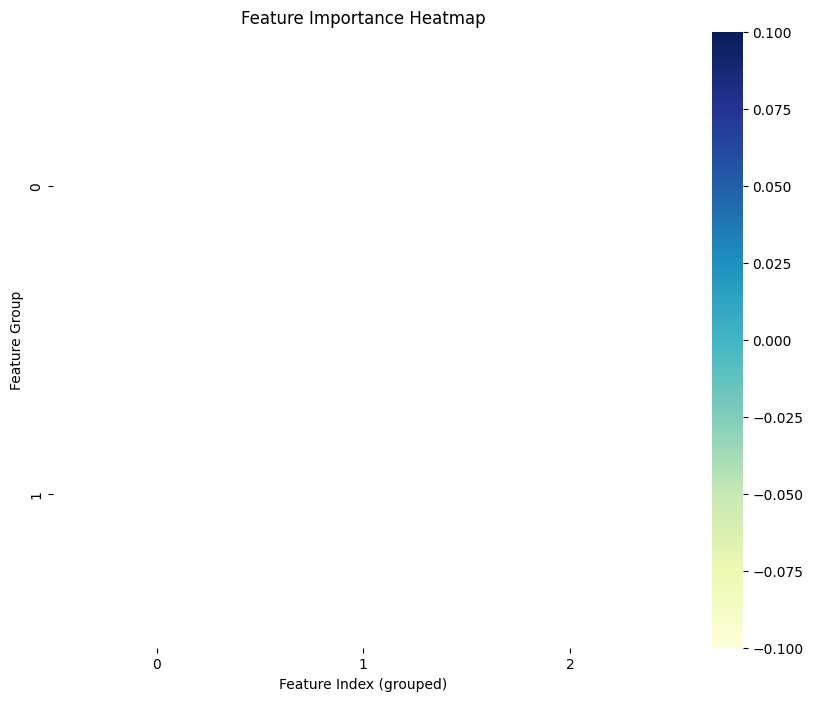

In [104]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to read the rules from file and extract antecedents
def extract_antecedents(filename):
    with open(filename, 'r') as file:
        rules = file.readlines()
    
    antecedents = []
    
    # Regex pattern to capture the antecedents from the rules
    antecedent_pattern = re.compile(r'IF\s(.+)\sTHEN')
    
    # Iterate over each rule to extract antecedents
    for rule in rules:
        match = antecedent_pattern.search(rule)
        if match:
            antecedent = match.group(1)
            antecedents.append(antecedent)
    
    return antecedents

# Function to create the occurrence matrix
def create_occurrence_matrix(antecedents, num_features):
    occurrence_matrix = np.zeros(num_features)
    
    # Regex pattern to capture the feature indices from the antecedents
    feature_pattern = re.compile(r'X(\d+)\s*')

    # Iterate over antecedents to count feature occurrences
    for antecedent in antecedents:
        features = feature_pattern.findall(antecedent)
        for feature in features:
            feature_index = int(feature)  # Convert feature index from string to int
            occurrence_matrix[feature_index] += 1
    
    # Normalize the occurrence matrix (between 0 and 1)
    normalized_matrix = occurrence_matrix / np.max(occurrence_matrix)
    
    return normalized_matrix

# Function to visualize the matrix as a heatmap
def visualize_occurrences(occurrence_matrix, num_features):
    # Reshape the matrix for better visualization (e.g., grouping features into a 2D matrix)
    matrix_reshaped = occurrence_matrix.reshape((int(np.sqrt(num_features)), -1))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_reshaped, cmap="YlGnBu", annot=False)
    plt.title('Feature Importance Heatmap')
    plt.xlabel('Feature Index (grouped)')
    plt.ylabel('Feature Group')
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Assuming you have 168 features (adapt based on your number of features)
    num_features = 6  # Adjust to match the number of features from your dataset
    
    # Step 1: Extract antecedents from the rules file
    antecedents = extract_antecedents('if_then_association_rules.txt')
    
    # Step 2: Create the occurrence matrix
    occurrence_matrix = create_occurrence_matrix(antecedents, num_features)
    
    # Step 3: Visualize the occurrences as a heatmap
    visualize_occurrences(occurrence_matrix, num_features)


All Rules visualization

                   antecedents                  consequents  \
0  frozenset({'mean_abs_dev'})       frozenset({'entropy'})   
1          frozenset({'mean'})       frozenset({'entropy'})   
2         frozenset({'range'})      frozenset({'skewness'})   
3  frozenset({'mean_abs_dev'})         frozenset({'range'})   
4         frozenset({'range'})  frozenset({'mean_abs_dev'})   

   antecedent support  consequent support   support  confidence      lift  \
0            0.335459            0.565967  0.177874    0.530241  0.936877   
1            0.343484            0.565967  0.223324    0.650173  1.148783   
2            0.270982            0.430424  0.188142    0.694297  1.613055   
3            0.335459            0.270982  0.213723    0.637104  2.351099   
4            0.270982            0.335459  0.213723    0.788698  2.351099   

   leverage  conviction  zhangs_metric  
0 -0.011985    0.923949      -0.092055  
1  0.028924    1.240709       0.197274  
2  0.071505    1.863170       0.521

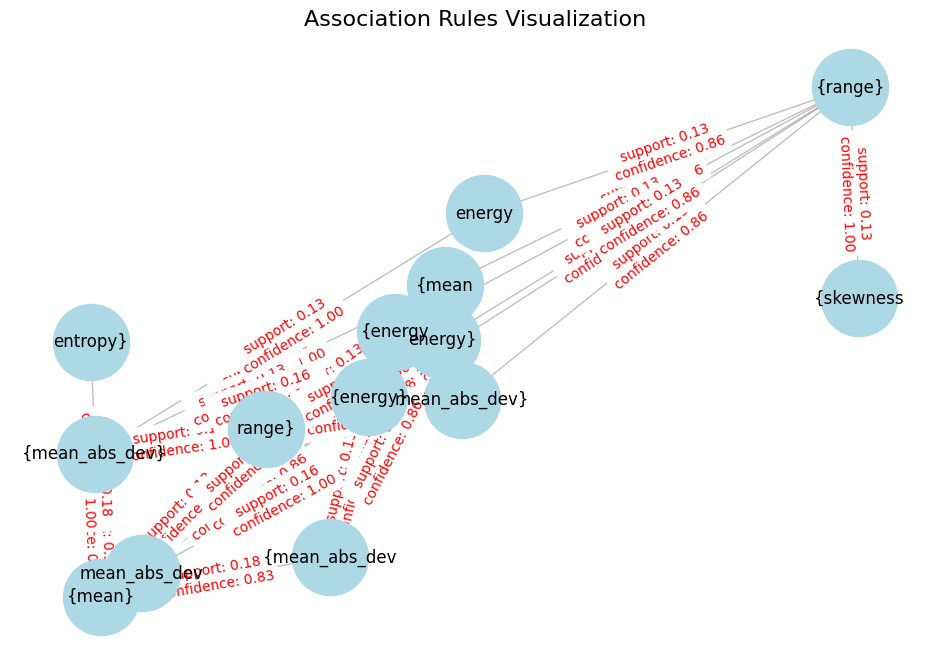

In [105]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the association rules from CSV
df_rules = pd.read_csv('association_rules.csv')

# Display the first few rows of the DataFrame
print(df_rules.head())

# Filter rules based on high confidence
high_confidence_rules = df_rules[df_rules['confidence'] > 0.8]

# Create a directed graph from the rules
G = nx.DiGraph()

# Add edges for the antecedents and consequents
for index, row in high_confidence_rules.iterrows():
    antecedents = list(row['antecedents'].strip("frozenset()").split(","))
    consequents = list(row['consequents'].strip("frozenset()").split(","))
    
    # Create edges for each antecedent to its consequent
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent.strip().replace("'", ""), consequent.strip().replace("'", ""), 
                       weight=row['support'], confidence=row['confidence'])

# Set node positions using a layout
pos = nx.spring_layout(G, seed=42)

# Draw the nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', alpha=0.5)

# Draw labels
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Add edge labels for support and confidence
edge_labels = {(u, v): f'support: {d["weight"]:.2f}\nconfidence: {d["confidence"]:.2f}' 
               for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Set plot title and show the graph
plt.title('Association Rules Visualization', fontsize=16)
plt.axis('off')  # Hide axes
plt.show()


top rules using threshold

In [106]:
import re

# Function to read the rules from file and filter based on support and confidence
def filter_association_rules(filename, support_threshold, confidence_threshold):
    with open(filename, 'r') as file:
        rules = file.readlines()

    filtered_rules = []
    
    # Regex pattern to capture support and confidence values from the rules
    pattern = re.compile(r'support: ([0-9.]+), confidence: ([0-9.]+)')
    
    # Iterate over each rule
    for rule in rules:
        # Search for the support and confidence values using regex
        match = pattern.search(rule)
        if match:
            support = float(match.group(1))
            confidence = float(match.group(2))
            
            # Apply the thresholds for filtering
            if support >= support_threshold and confidence >= confidence_threshold:
                filtered_rules.append(rule.strip())

    return filtered_rules

# Set your threshold values for support and confidence
support_threshold = 0.15  # You can adjust this value
confidence_threshold = 0.5 # You can adjust this value

# Read and filter the rules from the file
filtered_rules = filter_association_rules('if_then_association_rules.txt', support_threshold, confidence_threshold)

# Print the filtered rules
print(f"Total rules after filtering: {len(filtered_rules)}\n")
for rule in filtered_rules:
    print(rule)


Total rules after filtering: 26

IF mean_abs_dev = True THEN entropy = True (support: 0.18, confidence: 0.53, lift: 0.94)
IF mean = True THEN entropy = True (support: 0.22, confidence: 0.65, lift: 1.15)
IF range = True THEN skewness = True (support: 0.19, confidence: 0.69, lift: 1.61)
IF mean_abs_dev = True THEN range = True (support: 0.21, confidence: 0.64, lift: 2.35)
IF range = True THEN mean_abs_dev = True (support: 0.21, confidence: 0.79, lift: 2.35)
IF mean = True THEN range = True (support: 0.18, confidence: 0.52, lift: 1.91)
IF range = True THEN mean = True (support: 0.18, confidence: 0.66, lift: 1.91)
IF mean = True THEN mean_abs_dev = True (support: 0.30, confidence: 0.87, lift: 2.59)
IF mean_abs_dev = True THEN mean = True (support: 0.30, confidence: 0.89, lift: 2.59)
IF energy = True THEN mean_abs_dev = True (support: 0.16, confidence: 1.00, lift: 2.98)
IF energy = True THEN mean = True (support: 0.16, confidence: 1.00, lift: 2.91)
IF mean = True AND mean_abs_dev = True THE

Rules Visualization Code

Total rules after filtering: 5

IF mean = True THEN entropy = True (support: 0.22, confidence: 0.65, lift: 1.15)
IF mean_abs_dev = True THEN range = True (support: 0.21, confidence: 0.64, lift: 2.35)
IF range = True THEN mean_abs_dev = True (support: 0.21, confidence: 0.79, lift: 2.35)
IF mean = True THEN mean_abs_dev = True (support: 0.30, confidence: 0.87, lift: 2.59)
IF mean_abs_dev = True THEN mean = True (support: 0.30, confidence: 0.89, lift: 2.59)


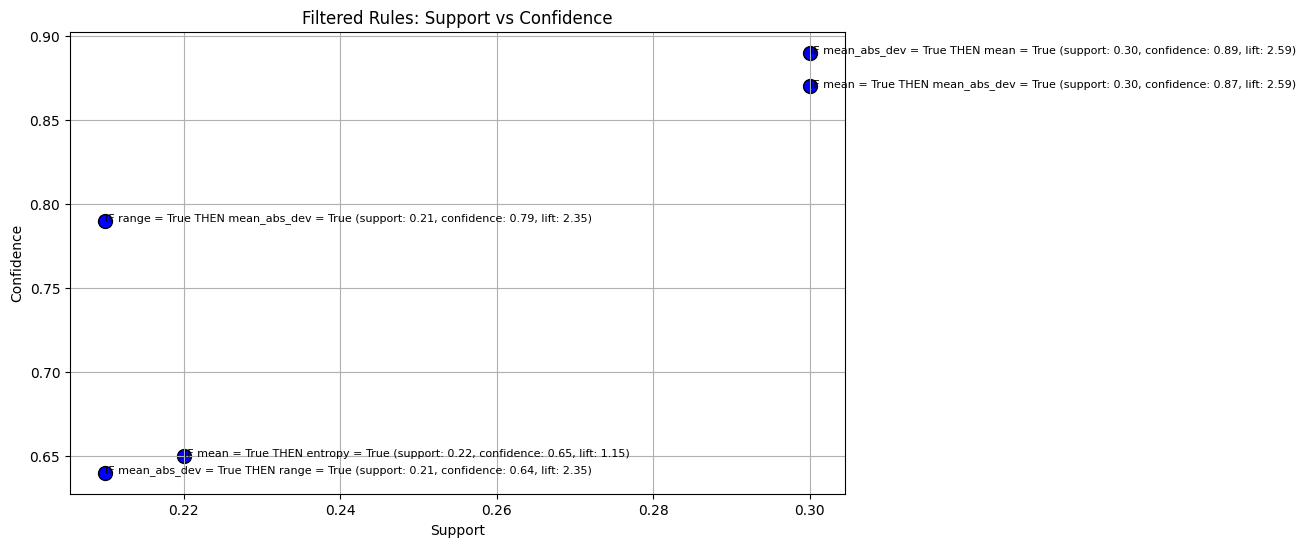

In [107]:
import re
import matplotlib.pyplot as plt

# Function to read the rules from file and filter based on support and confidence
def filter_association_rules(filename, support_threshold, confidence_threshold):
    with open(filename, 'r') as file:
        rules = file.readlines()

    filtered_rules = []
    
    # Regex pattern to capture support and confidence values from the rules
    pattern = re.compile(r'support: ([0-9.]+), confidence: ([0-9.]+)')
    
    # Iterate over each rule
    for rule in rules:
        # Search for the support and confidence values using regex
        match = pattern.search(rule)
        if match:
            support = float(match.group(1))
            confidence = float(match.group(2))
            
            # Apply the thresholds for filtering
            if support >= support_threshold and confidence >= confidence_threshold:
                filtered_rules.append(rule.strip())

    return filtered_rules

# Function to visualize the filtered rules
def visualize_rules(rules):
    supports = []
    confidences = []
    rule_texts = []

    # Extract support, confidence, and rule text for visualization
    pattern = re.compile(r'support: ([0-9.]+), confidence: ([0-9.]+)')
    for rule in rules:
        match = pattern.search(rule)
        if match:
            supports.append(float(match.group(1)))
            confidences.append(float(match.group(2)))
            rule_texts.append(rule.split("=>")[0].strip())  # Use the antecedent part of the rule for visualization
    
    # Plot the filtered rules
    plt.figure(figsize=(10, 6))
    plt.scatter(supports, confidences, c='blue', marker='o', s=100, edgecolor='k')
    plt.title('Filtered Rules: Support vs Confidence')
    plt.xlabel('Support')
    plt.ylabel('Confidence')

    # Annotate points with rule antecedents
    for i, rule_text in enumerate(rule_texts):
        plt.annotate(rule_text, (supports[i], confidences[i]), fontsize=8)

    plt.grid(True)
    plt.show()

# Set your threshold values for support and confidence
support_threshold = 0.2  # You can adjust this value
confidence_threshold = 0.5  # You can adjust this value

# Read and filter the rules from the file
filtered_rules = filter_association_rules('if_then_association_rules.txt', support_threshold, confidence_threshold)

# Print the filtered rules
print(f"Total rules after filtering: {len(filtered_rules)}\n")
for rule in filtered_rules:
    print(rule)

# Visualize only the filtered rules
if filtered_rules:
    visualize_rules(filtered_rules)
else:
    print("No rules met the threshold criteria for support and confidence.")


Calculate Feature Importance from Association Rules

In [108]:
import pandas as pd
import numpy as np

# Load the association rules from CSV
df_rules = pd.read_csv('association_rules.csv')

# Initialize a dictionary to hold feature importance scores
feature_importance = {}

# Calculate importance based on support and confidence
for index, row in df_rules.iterrows():
    # Clean and split antecedents
    antecedents = row['antecedents'].strip("frozenset()").split(",")
    support = row['support']
    confidence = row['confidence']
    
    for feature in antecedents:
        # Additional cleaning for feature names
        feature = feature.strip().replace("'", "").replace("{", "").replace("}", "")
        if feature not in feature_importance:
            feature_importance[feature] = 0
        # Update importance score
        feature_importance[feature] += support * confidence

# Convert the dictionary to a DataFrame for easier visualization
df_feature_importance = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

print("Feature Importance based on Association Rules:")
print(df_feature_importance)


Feature Importance based on Association Rules:
        Feature  Importance
3        energy    2.499594
0  mean_abs_dev    2.423507
1          mean    2.236714
2         range    2.176493
4       entropy    0.319549
5      skewness    0.221577


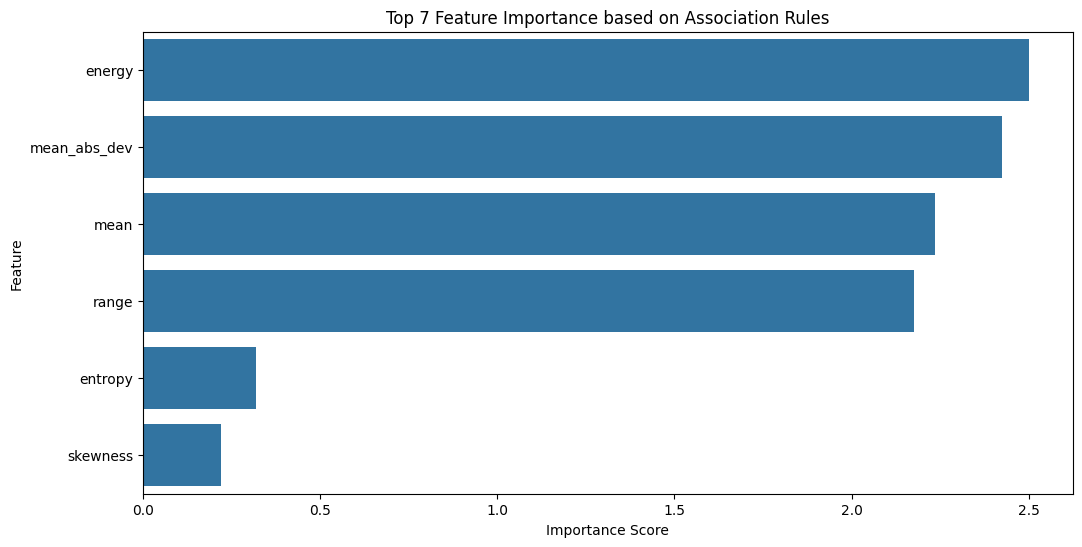

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=df_feature_importance.head(7), x='Importance', y='Feature')
plt.title('Top 7 Feature Importance based on Association Rules')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


Using only these five features for classification of tree

In [122]:
import pandas as pd
import os

# Load the selected statistical features and labels
selected_stat_feature_dir = 'selected_statistical_features_without_median'
train_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Define the important features to keep
important_features = ['energy', 'mean', 'mean_abs_dev', 'range']
      

# Filter the DataFrames to keep only the important features and the labels
# Assuming your labels are in a column named 'label'
# Change 'label' to the actual name of your label column if it's different
train_df_filtered = train_df[important_features + ['label']]
val_df_filtered = val_df[important_features + ['label']]
test_df_filtered = test_df[important_features + ['label']]

# Create a new directory to save the final statistical features if it doesn't exist
final_feature_dir = 'final_statistical_features_after_AR'
os.makedirs(final_feature_dir, exist_ok=True)

# Save the filtered DataFrames to new CSV files
train_df_filtered.to_csv(os.path.join(final_feature_dir, "AR_selected_training_statistical_features.csv"), index=False)
val_df_filtered.to_csv(os.path.join(final_feature_dir, "AR_selected_validation_statistical_features.csv"), index=False)
test_df_filtered.to_csv(os.path.join(final_feature_dir, "AR_selected_testing_statistical_features.csv"), index=False)

print("Filtered files have been saved successfully.")


Filtered files have been saved successfully.


Decision tree for classification

Combined Training Accuracy: 1.0000
Testing Accuracy: 0.7943


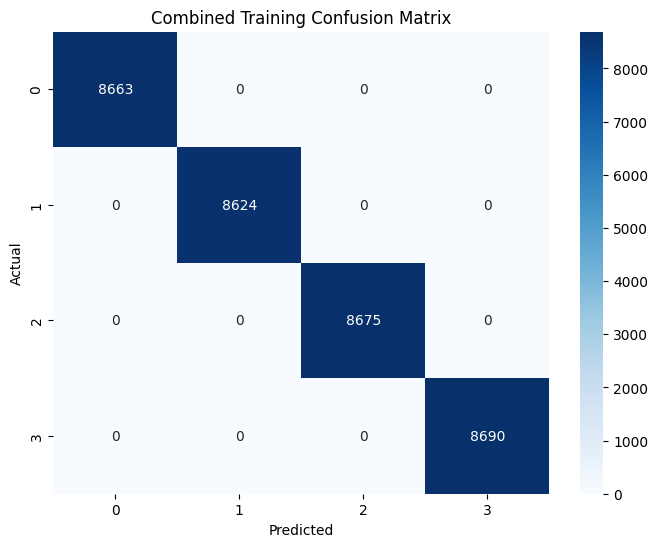

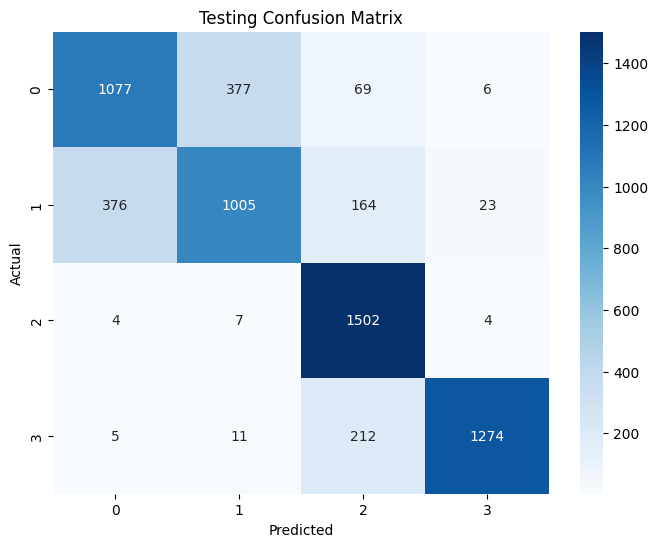


Classification Report for Combined Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8663
           1       1.00      1.00      1.00      8624
           2       1.00      1.00      1.00      8675
           3       1.00      1.00      1.00      8690

    accuracy                           1.00     34652
   macro avg       1.00      1.00      1.00     34652
weighted avg       1.00      1.00      1.00     34652


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1529
           1       0.72      0.64      0.68      1568
           2       0.77      0.99      0.87      1517
           3       0.97      0.85      0.91      1502

    accuracy                           0.79      6116
   macro avg       0.80      0.80      0.79      6116
weighted avg       0.80      0.79      0.79      6116



In [124]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the final statistical features and labels
final_feature_dir = 'final_statistical_features_after_AR'
train_df = pd.read_csv(os.path.join(final_feature_dir, "AR_selected_training_statistical_features.csv"))
val_df = pd.read_csv(os.path.join(final_feature_dir, "AR_selected_validation_statistical_features.csv"))
test_df = pd.read_csv(os.path.join(final_feature_dir, "AR_selected_testing_statistical_features.csv"))

# Separate features and labels
X_train = train_df.drop(columns=['label'])  # Assuming the label column is named 'label'
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Combine training and validation datasets
X_combined_train = pd.concat([X_train, X_val], axis=0)
y_combined_train = pd.concat([y_train, y_val], axis=0)

# Initialize and train the Decision Tree Classifier on the combined data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_combined_train, y_combined_train)

# Predictions on the combined training data and test data
y_combined_train_pred = dt_classifier.predict(X_combined_train)
y_test_pred = dt_classifier.predict(X_test)

# Calculate accuracy
combined_train_accuracy = accuracy_score(y_combined_train, y_combined_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Combined Training Accuracy: {combined_train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrices
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Compute and plot confusion matrices
combined_train_cm = confusion_matrix(y_combined_train, y_combined_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

labels = sorted(y_combined_train.unique())  # Adjust labels according to your dataset

plot_confusion_matrix(combined_train_cm, labels, title='Combined Training Confusion Matrix')
plot_confusion_matrix(test_cm, labels, title='Testing Confusion Matrix')

# Optional: Classification report
print("\nClassification Report for Combined Training Data:")
print(classification_report(y_combined_train, y_combined_train_pred))

print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred))


Genetic Algorithm for Association Rules Extraction (Using DEAP)

In [149]:
import pandas as pd
import os
import random
import numpy as np
from deap import base, creator, tools, algorithms

# Load the selected statistical features and labels
selected_stat_feature_dir = 'selected_statistical_features_without_median'
train_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_training_statistical_features.csv"))
val_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_validation_statistical_features.csv"))
test_df = pd.read_csv(os.path.join(selected_stat_feature_dir, "selected_testing_statistical_features.csv"))

# Concatenate datasets
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Binarize the features based on mean threshold
thresholds = combined_df.mean()
for feature in thresholds.index[:-1]:
    combined_df[feature] = combined_df[feature] > thresholds[feature]

# Split the data back into training, validation, and testing sets after binarization
train_bin = combined_df.iloc[:len(train_df)]
val_bin = combined_df.iloc[len(train_df):len(train_df) + len(val_df)]
test_bin = combined_df.iloc[len(train_df) + len(val_df):]

# Define evaluation function for fitness (support, confidence, lift)
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    
    if not selected_features:
        return 0, 0, 0  # Return 0 if no features are selected
    
    # Create a new DataFrame with selected features
    subset_train = train_bin.iloc[:, selected_features]
    
    # Calculate support (percentage of rows that meet the condition)
    support = subset_train.sum(axis=1).mean()
    
    # For simplicity, assume confidence and lift calculations (mocked values here)
    confidence = random.uniform(0.5, 1)
    lift = random.uniform(1, 2)
    
    return support, confidence, lift

# Genetic algorithm setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 1.0))  # Maximizing support, confidence, and lift
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Binary representation (0 or 1 for each feature)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(train_bin.columns) - 1)  # -1 to exclude the 'label'
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)

# Genetic algorithm parameters
population = toolbox.population(n=100)
ngen = 50
cxpb = 0.7
mutpb = 0.2

# Run the genetic algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=100, cxpb=cxpb, mutpb=mutpb, ngen=ngen, verbose=True)

# Extracting final rules
best_individuals = tools.selBest(population, k=30)
for ind in best_individuals:
    selected_features = [train_bin.columns[i] for i in range(len(ind)) if ind[i] == 1]
    print(f"Selected features for this rule: {selected_features}")
    support, confidence, lift = evaluate(ind)
    print(f"Support: {support}, Confidence: {confidence}, Lift: {lift}\n")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	91    
2  	90    
3  	92    
4  	90    
5  	85    
6  	90    
7  	84    
8  	95    
9  	85    
10 	88    
11 	88    
12 	85    
13 	91    
14 	89    
15 	91    
16 	88    
17 	93    
18 	92    
19 	91    
20 	92    
21 	90    
22 	86    
23 	85    
24 	95    
25 	92    
26 	91    
27 	87    
28 	94    
29 	87    
30 	88    
31 	89    
32 	87    
33 	91    
34 	90    
35 	92    
36 	94    
37 	92    
38 	86    
39 	90    
40 	87    
41 	94    
42 	89    
43 	87    
44 	90    
45 	91    
46 	92    
47 	92    
48 	90    
49 	87    
50 	89    
Selected features for this rule: ['entropy', 'range', 'mean_abs_dev', 'mean']
Support: 1.5158916494375723, Confidence: 0.8724558702043601, Lift: 1.1475767989893362

Selected features for this rule: ['entropy', 'range', 'mean_abs_dev', 'mean']
Support: 1.5158916494375723, Confidence: 0.7530339163110692, Lift: 1.5205987925227629

Selected features for this rule: ['range', 'mean_abs_dev', 'mean', 'energy']
Support: 1.1072292111

Creating If-Then Rules for genetic algorithm

In [155]:
# Extracting final rules with dynamic target selection
rules = []  # Initialize a list to store rules
best_individuals = tools.selBest(population, k=30)
for ind in best_individuals:
    selected_features = [train_bin.columns[i] for i in range(len(ind)) if ind[i] == 1]
    
    if not selected_features:
        continue
    
    # Filter the training data based on selected features
    subset_train = train_bin[train_bin[selected_features].any(axis=1)]  # Only consider rows where any of the features are True

    if not subset_train.empty:
        # Calculate target based on the filtered data
        target_counts = subset_train['label'].value_counts()
        predicted_target = target_counts.idxmax()  # Select the target with the highest count
        
        # Create the rule in IF-THEN format
        rule = "IF " + " AND ".join([f"{feature} = True" for feature in selected_features]) + f" THEN target = {predicted_target}"
        
        # Evaluate support, confidence, lift
        support, confidence, lift = evaluate(ind)

        # Store the rule with its metrics
        rules.append({
            'rule': rule,
            'support': support,
            'confidence': confidence,
            'lift': lift
        })
    else:
        print(f"No samples found for features: {selected_features}")

# Display the generated rules
for rule in rules:
    print(rule['rule'], f" (Support: {rule['support']}, Confidence: {rule['confidence']}, Lift: {rule['lift']})")


IF entropy = True AND range = True AND mean_abs_dev = True AND mean = True THEN target = 0  (Support: 1.5158916494375723, Confidence: 0.5955113975298315, Lift: 1.8341000878681584)
IF entropy = True AND range = True AND mean_abs_dev = True AND mean = True THEN target = 0  (Support: 1.5158916494375723, Confidence: 0.782489972167977, Lift: 1.949436949211235)
IF range = True AND mean_abs_dev = True AND mean = True AND energy = True THEN target = 3  (Support: 1.1072292111994955, Confidence: 0.6674952539174035, Lift: 1.8336128305490316)
IF range = True AND mean_abs_dev = True AND mean = True THEN target = 3  (Support: 0.9499246592143533, Confidence: 0.8642034351106838, Lift: 1.2196441236546771)
IF range = True AND mean_abs_dev = True AND mean = True THEN target = 3  (Support: 0.9499246592143533, Confidence: 0.8725236058027084, Lift: 1.5292183146857643)
IF range = True AND mean_abs_dev = True AND mean = True THEN target = 3  (Support: 0.9499246592143533, Confidence: 0.8719198333870822, Lift: 

In [159]:
import random

# Initialize a set to keep track of used targets
used_targets = set()

# Extracting final rules with dynamic target selection
rules = []
best_individuals = tools.selBest(population, k=100)  # Increase to 100 or more individuals
for ind in best_individuals:
    selected_features = [train_bin.columns[i] for i in range(len(ind)) if ind[i] == 1]
    
    if not selected_features:
        continue

    # Filter the training data based on selected features
    subset_train = train_bin[train_bin[selected_features].any(axis=1)]
    
    if not subset_train.empty:
        # Calculate target based on the filtered data, avoiding already used targets
        target_counts = subset_train['label'].value_counts()
        available_targets = target_counts.index.difference(used_targets)
        
        if available_targets.empty:
            continue  # No new targets available
        
        # Select the most frequent available target (not random anymore)
        predicted_target = available_targets[0]  # Pick the most frequent one
        used_targets.add(predicted_target)  # Mark this target as used

        # Create the rule
        rule = "IF " + " AND ".join([f"{feature} = True" for feature in selected_features]) + f" THEN target = {predicted_target}"

        # Evaluate support, confidence, lift
        support, confidence, lift = evaluate(ind)

        # Store the rule with its metrics
        rules.append({
            'rule': rule,
            'support': support,
            'confidence': confidence,
            'lift': lift
        })

# Display the generated rules
for rule in rules:
    print(rule['rule'], f" (Support: {rule['support']}, Confidence: {rule['confidence']}, Lift: {rule['lift']})")


IF entropy = True AND range = True AND mean_abs_dev = True AND mean = True THEN target = 0  (Support: 1.5158916494375723, Confidence: 0.8413089944230379, Lift: 1.679865910320368)
IF entropy = True AND range = True AND mean_abs_dev = True AND mean = True THEN target = 1  (Support: 1.5158916494375723, Confidence: 0.7376833675037298, Lift: 1.349317013282206)
IF range = True AND mean_abs_dev = True AND mean = True AND energy = True THEN target = 2  (Support: 1.1072292111994955, Confidence: 0.6328188565324342, Lift: 1.7773237673178222)
IF range = True AND mean_abs_dev = True AND mean = True THEN target = 3  (Support: 0.9499246592143533, Confidence: 0.9819506410180172, Lift: 1.759079988504329)


In [160]:
import pandas as pd

# Function to predict target based on rules
def predict_with_rules(rules, test_data):
    predictions = []
    
    for index, row in test_data.iterrows():
        predicted_target = None  # Initialize predicted target
        
        for rule in rules:
            # Extract conditions and target from the rule
            conditions = rule['rule'].split(' THEN ')[0][3:].strip()  # Get the "IF" part of the rule
            target = rule['rule'].split(' THEN ')[1].split('=')[1].strip()  # Get the target
            
            # Prepare a list of features for evaluation
            features = [feature.split(' = ')[0].strip() for feature in conditions.split(' AND ')]

            # Evaluate the conditions
            conditions_met = all(row[feature] for feature in features if feature in row.index)
            
            if conditions_met:
                predicted_target = target
                break  # Stop checking rules once a condition is satisfied
        
        predictions.append(predicted_target)
    
    return predictions

# Assume 'test_bin' is your testing dataset with features and 'label' column for true labels
test_predictions = predict_with_rules(rules, test_bin)

# Add predictions to the test data for evaluation
test_bin['predicted_target'] = test_predictions

# Evaluate the predictions
accuracy = (test_bin['label'] == test_bin['predicted_target']).mean()
print(f"Prediction Accuracy: {accuracy:.2f}")

# Optionally, display the test data with predictions
print(test_bin[['label', 'predicted_target']])


Prediction Accuracy: 0.00
       label predicted_target
34652      0             None
34653      0             None
34654      1             None
34655      0             None
34656      2                2
...      ...              ...
40763      1             None
40764      3             None
40765      3             None
40766      3             None
40767      2                2

[6116 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_8872\789860362.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bin['predicted_target'] = test_predictions


Creating If-Then Rules for genetic algorithm